In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('paper')

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [3]:
from statsmodels.tools.eval_measures import rmse

In [4]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [5]:
sns.set_context('talk')
sns.set_style('white')

In [6]:
plt.rcParams["figure.dpi"] = 300

In [7]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MED4',  'MIT9312','MIT0604', 'Natl2A', 'MIT9313']
ppallete = [ '#62A586', '#face6e','#f79934', '#7A9BC8', '#F47681', ]
psizes = [150,120,200,120,350]
pmarkers = ['o', 's', '^', 'D', '*']

# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['P', 'X', 'h', '<','>']
apallete = ['#6dad36', '#c7e89f', '#f5c4e1', '#d5579d', '#8a0850']

aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']

In [8]:
PRO_COLOR = 'MediumSeaGreen'
ALT_COLOR = 'Gold'

In [9]:
dflist=list()
for i in os.listdir('fcmfiles'):
    if i.endswith('.csv'):
        d = pd.read_csv(os.path.join('fcmfiles', i))
        n = os.path.splitext(i)[0]
        _, experiment, day = n.split('_')
        d['experiment'] = experiment
        d['day'] = day.replace('Days','')
        dflist.append(d)
df = pd.concat(dflist)
df.loc[df.PRO == 'C9B', 'PRO'] = 'MIT0604'

In [10]:
df.head()

PRO  ALT sample         PRO.1         ALT.1 experiment  day
0     MED4  1A3     1A  7.485642e+06  2.992351e+07       exp1  100
1     MED4  1A3     1B  6.720907e+06  2.159764e+07       exp1  100
2     MED4  1A3     1C  1.121335e+07  1.742056e+07       exp1  100
3  MIT9313  1A3     2A  1.415617e+06  5.134250e+06       exp1  100
4  MIT9313  1A3     2B  1.018640e+06  4.885134e+06       exp1  100

In [11]:
df.isna().sum()

PRO           45
ALT           45
sample         0
PRO.1         36
ALT.1         73
experiment     0
day            0
dtype: int64

In [12]:
df = df.dropna(subset=['PRO.1', 'ALT.1'], how='all')

In [13]:
df['day'] = pd.to_numeric(df['day'])

In [14]:
for c in df.columns:
    if c in ['PRO.1', 'ALT.1']:
        continue
    print(c, df[c].unique())

PRO ['MED4' 'MIT9313' 'MIT9312' 'Natl2A' 'MIT0604' nan]
ALT ['1A3' 'DE' 'DE1' 'BS11' 'ATCC' nan]
sample ['1A' '1B' '1C' '2A' '2B' '2C' '3A' '3B' '3C' '4A' '4B' '4C' '5A' '5B'
 '5C' '6A' '6B' '6C' '7A' '7B' '7C' '8A' '8B' '8C' '9A' '9B' '9C' '10A'
 '10B' '10C' '11A' '11B' '11C' '12A' '12B' '12C' '13A' '13B' '13C' '14A'
 '14B' '14C' '15A' '15B' '15C' '16A' '16B' '16C' '17A' '17B' '17C' '18A'
 '18B' '18C' '19A' '19B' '19C' '20A' '20B' '20C' '21A' '21B' '21C' '22A'
 '22B' '22C' '23A' '23B' '23C' '24A' '24B' '24C' '25C' '26A' '26B' '26C'
 '27A' '27B' '27C' '28A' '28B' '28C' '29A' '29B' '29C' '30A' '30B' '30C'
 '31A' '31B' '31C' '32A' '32B' '32C' '33A' '33B' '33C' '34A' '34B' '35A'
 '35B' '34C' '35C' '25A' '25B']
experiment ['exp1' 'exp3' 'exp4']
day [100 140  60]


In [15]:
df.dtypes

PRO            object
ALT            object
sample         object
PRO.1         float64
ALT.1         float64
experiment     object
day             int64
dtype: object

In [16]:
df.loc[df['PRO'].isna() & df.experiment.isin(['exp1']) & df.day.isin([140]), 'PRO.1'] = np.NaN



In [17]:
df = df.loc[df['sample'] != '26C']

In [18]:
df.loc[df['experiment'] != 'exp1', 'day'] = df.loc[df['experiment'] != 'exp1', 'experiment']  + '_' + df.loc[df['experiment'] != 'exp1', 'day'].astype(str)


In [19]:
df.isna().sum()

PRO           43
ALT           42
sample         0
PRO.1         43
ALT.1         62
experiment     0
day            0
dtype: int64

In [20]:
# cell quotas (fg/cell)

PRO_N_min = 3.5
PRO_N_max = 10
PRO_C_min = 17
PRO_C_max = 50



ALT_N_min = 13
ALT_N_max = 25
ALT_C_min = 56
ALT_C_max = 88

MW_C = 12
MW_N = 14

PRO_REL_SIZE = {
    'MED4' : 1, 
    'MIT9312' : 1,
    'MIT0604' : 1,
    'Natl2A' :  1.5,    
     'MIT9313' :  2,
}



In [21]:
# The values for the C and N quotas vary quite widely between studies (e.g. see Table S1 in the SI of Dalit’s paper, attached) but in general:
# MED4 and MIT9312 are about the same
# NATL is about 1.5x larger
# MIT9313 is about 2x larger
# Alteromonas is about 3x larger than MED4

base_pro_N = 7
PRO_N_QUOTA = {
    'MED4' : base_pro_N, 
    'MIT9312' : base_pro_N,
    'MIT0604' : base_pro_N,
    'Natl2A' : base_pro_N * 1.5,    
     'MIT9313' : base_pro_N * 2,
}

ALT_N_quota = base_pro_N * 3


In [22]:
porder

['MED4', 'MIT9312', 'MIT0604', 'Natl2A', 'MIT9313']

In [23]:
df['culture'] = 'Co_Culture'
df.loc[df['PRO'].isna(), 'culture'] = 'ALT Only'
df.loc[df['ALT'].isna(), 'culture'] = 'PRO Only'


In [24]:
df['pair'] = df['PRO'] + ',' + df['ALT']
df.loc[df['PRO'].isna(), 'pair'] = df.loc[df['PRO'].isna(),'ALT']
df.loc[df['ALT'].isna(), 'pair'] = df.loc[df['ALT'].isna(),'PRO']


In [25]:
df.head()

PRO  ALT sample         PRO.1         ALT.1 experiment  day  \
0     MED4  1A3     1A  7.485642e+06  2.992351e+07       exp1  100   
1     MED4  1A3     1B  6.720907e+06  2.159764e+07       exp1  100   
2     MED4  1A3     1C  1.121335e+07  1.742056e+07       exp1  100   
3  MIT9313  1A3     2A  1.415617e+06  5.134250e+06       exp1  100   
4  MIT9313  1A3     2B  1.018640e+06  4.885134e+06       exp1  100   

      culture         pair  
0  Co_Culture     MED4,1A3  
1  Co_Culture     MED4,1A3  
2  Co_Culture     MED4,1A3  
3  Co_Culture  MIT9313,1A3  
4  Co_Culture  MIT9313,1A3

In [26]:
# fg to umol
# mass  (g) = conc (mol/L) X volume (L) x MW (g/mol)

# cell/ml x fg/cell = fg/ml
# fg/ml * 1e9 / mw(g/mol)  = umol/ml 


In [27]:
# 100 nmol / L = 

# umol / L   * 1e3 (umol->nmol)=  nmol / l
DN = 100 + 20 

In [28]:
initial_N_min = PRO_N_min * 1e6 * 1e-6 / MW_N +  ALT_N_min * 1e7* 1e-6 / MW_N + DN
initial_N_max = PRO_N_max * 1e6 * 1e-6 / MW_N +  ALT_N_max * 1e7* 1e-6 / MW_N + DN
initial_N_min, initial_N_max

(129.53571428571428, 138.57142857142858)

In [29]:
PRO_N_min * 1e6 * 1e-6 / MW_N , PRO_N_max * 1e6 * 1e-6 / MW_N , ALT_N_min * 1e7* 1e-6 / MW_N ,  ALT_N_max * 1e7* 1e-6 / MW_N 


(0.25, 0.7142857142857143, 9.285714285714286, 17.857142857142858)

In [30]:
initial_C_min = PRO_C_min * 1e6 * 1e-6 / MW_C +  ALT_C_min * 1e7* 1e-6 / MW_C + 120
initial_C_max = PRO_C_max * 1e6 * 1e-6 / MW_C +  ALT_C_max * 1e7* 1e-6 / MW_C + 120
initial_C_min, initial_C_max

(168.08333333333331, 197.5)

In [31]:
PRO_C_min * 1e6 * 1e-6 / MW_C , PRO_C_max * 1e6 * 1e-6 / MW_C , ALT_C_min * 1e7* 1e-6 / MW_C ,  ALT_C_max * 1e7* 1e-6 / MW_C


(1.4166666666666667, 4.166666666666667, 46.666666666666664, 73.33333333333333)

In [32]:

# umol / l

# umol/l        = cells/ml    * fg/cell   *  femto-> micro  / ml->L/ g/mol
# umol/l        = cells/ml    * fg/cell   *  1e-9  / 1e-3  / g/mol

df['C[PRO] min'] = df['PRO'].map(PRO_REL_SIZE) * df['PRO.1'] * PRO_C_min * 1e-6 / MW_C
df['C[PRO] max'] = df['PRO'].map(PRO_REL_SIZE) * df['PRO.1'] * PRO_C_max * 1e-6 / MW_C
df['N[PRO] min'] = df['PRO'].map(PRO_REL_SIZE) * df['PRO.1'] * PRO_N_min * 1e-6 / MW_N
df['N[PRO] max'] = df['PRO'].map(PRO_REL_SIZE) * df['PRO.1'] * PRO_N_max * 1e-6 / MW_N

df['C[ALT] min'] = df['ALT.1'] * ALT_C_min * 1e-6 / MW_C
df['C[ALT] max'] = df['ALT.1'] * ALT_C_max * 1e-6 / MW_C
df['N[ALT] min'] = df['ALT.1'] * ALT_N_min * 1e-6 / MW_N
df['N[ALT] max'] = df['ALT.1'] * ALT_N_max * 1e-6 / MW_N


In [33]:
df['C[Total] min'] = df['C[ALT] min'] + df['C[PRO] min']
df['C[Total] max'] = df['C[ALT] max'] + df['C[PRO] max']
df['N[Total] min'] = df['N[ALT] min'] + df['N[PRO] min']
df['N[Total] max'] = df['N[ALT] max'] + df['N[PRO] max']

df.loc[df['culture'].isin(['ALT Only']), 'C[Total] min'] = df.loc[df['culture'].isin(['ALT Only']), 'C[ALT] min']
df.loc[df['culture'].isin(['ALT Only']), 'C[Total] max'] = df.loc[df['culture'].isin(['ALT Only']), 'C[ALT] max']
df.loc[df['culture'].isin(['ALT Only']), 'N[Total] min'] = df.loc[df['culture'].isin(['ALT Only']), 'N[ALT] min']
df.loc[df['culture'].isin(['ALT Only']), 'N[Total] max'] = df.loc[df['culture'].isin(['ALT Only']), 'N[ALT] max']

df.loc[df['culture'].isin(['PRO Only']), 'C[Total] min'] = df.loc[df['culture'].isin(['PRO Only']), 'C[PRO] min']
df.loc[df['culture'].isin(['PRO Only']), 'C[Total] max'] = df.loc[df['culture'].isin(['PRO Only']), 'C[PRO] max']
df.loc[df['culture'].isin(['PRO Only']), 'N[Total] min'] = df.loc[df['culture'].isin(['PRO Only']), 'N[PRO] min']
df.loc[df['culture'].isin(['PRO Only']), 'N[Total] max'] = df.loc[df['culture'].isin(['PRO Only']), 'N[PRO] max']


In [34]:
df['percent_N'] = df['N[Total] min'] / initial_N_max

In [35]:
df['percent_PRO'] = df['N[PRO] min'] / df['N[Total] min'] 

In [36]:
df['culture'].unique()

array(['Co_Culture', 'PRO Only', 'ALT Only'], dtype=object)

In [37]:
for d in df.day.unique():
    mean_alt = df.loc[df['day'].isin([d]) & df['culture'].isin(['ALT Only'])].groupby('ALT')['N[ALT] min'].mean()
    df.loc[df['day'].isin([d]) ,'ALT_percent_increase'] = df.loc[df['day'].isin([d]),'N[ALT] min']  - df.loc[df['day'].isin([d]) ,'ALT'].map(mean_alt) / df.loc[df['day'].isin([d]),'N[ALT] min']

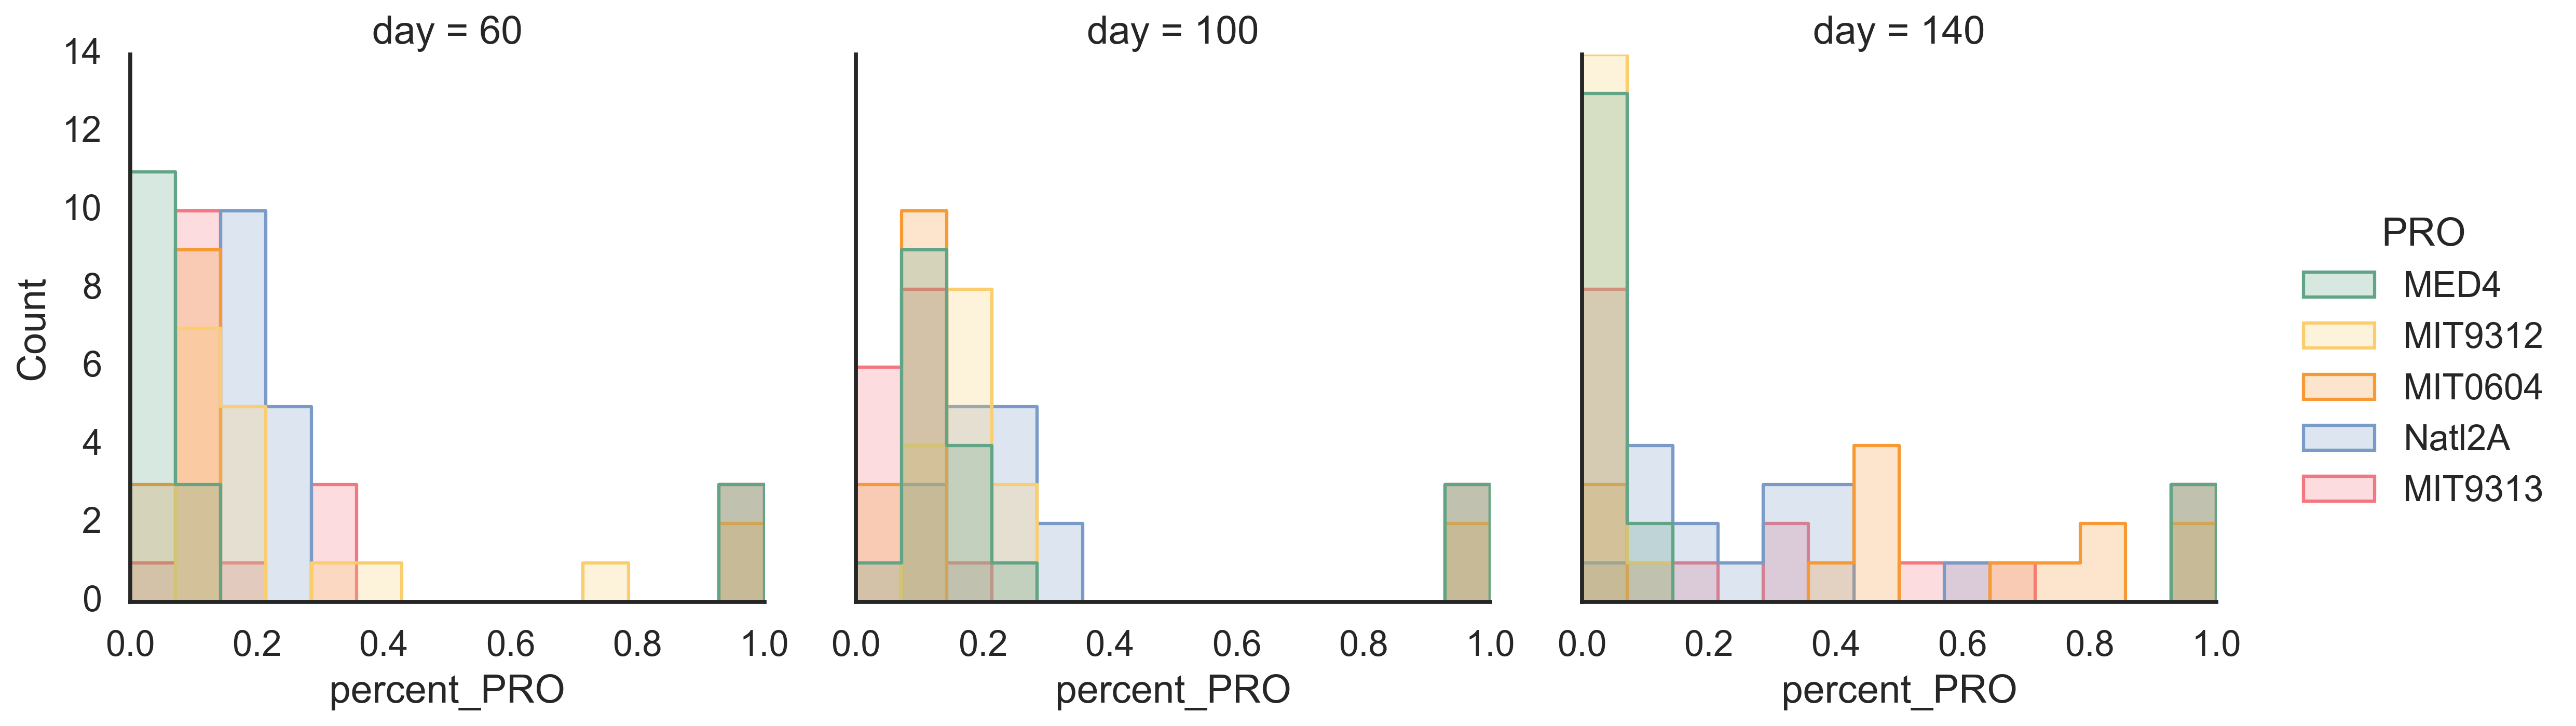

In [38]:
 sns.displot(
     data = df.loc[df.experiment.isin(['exp1'])], x='percent_PRO',
     hue='PRO', palette=ppallete, hue_order=porder, col='day', element='step',
 ) #.set(xlim=(0,2))

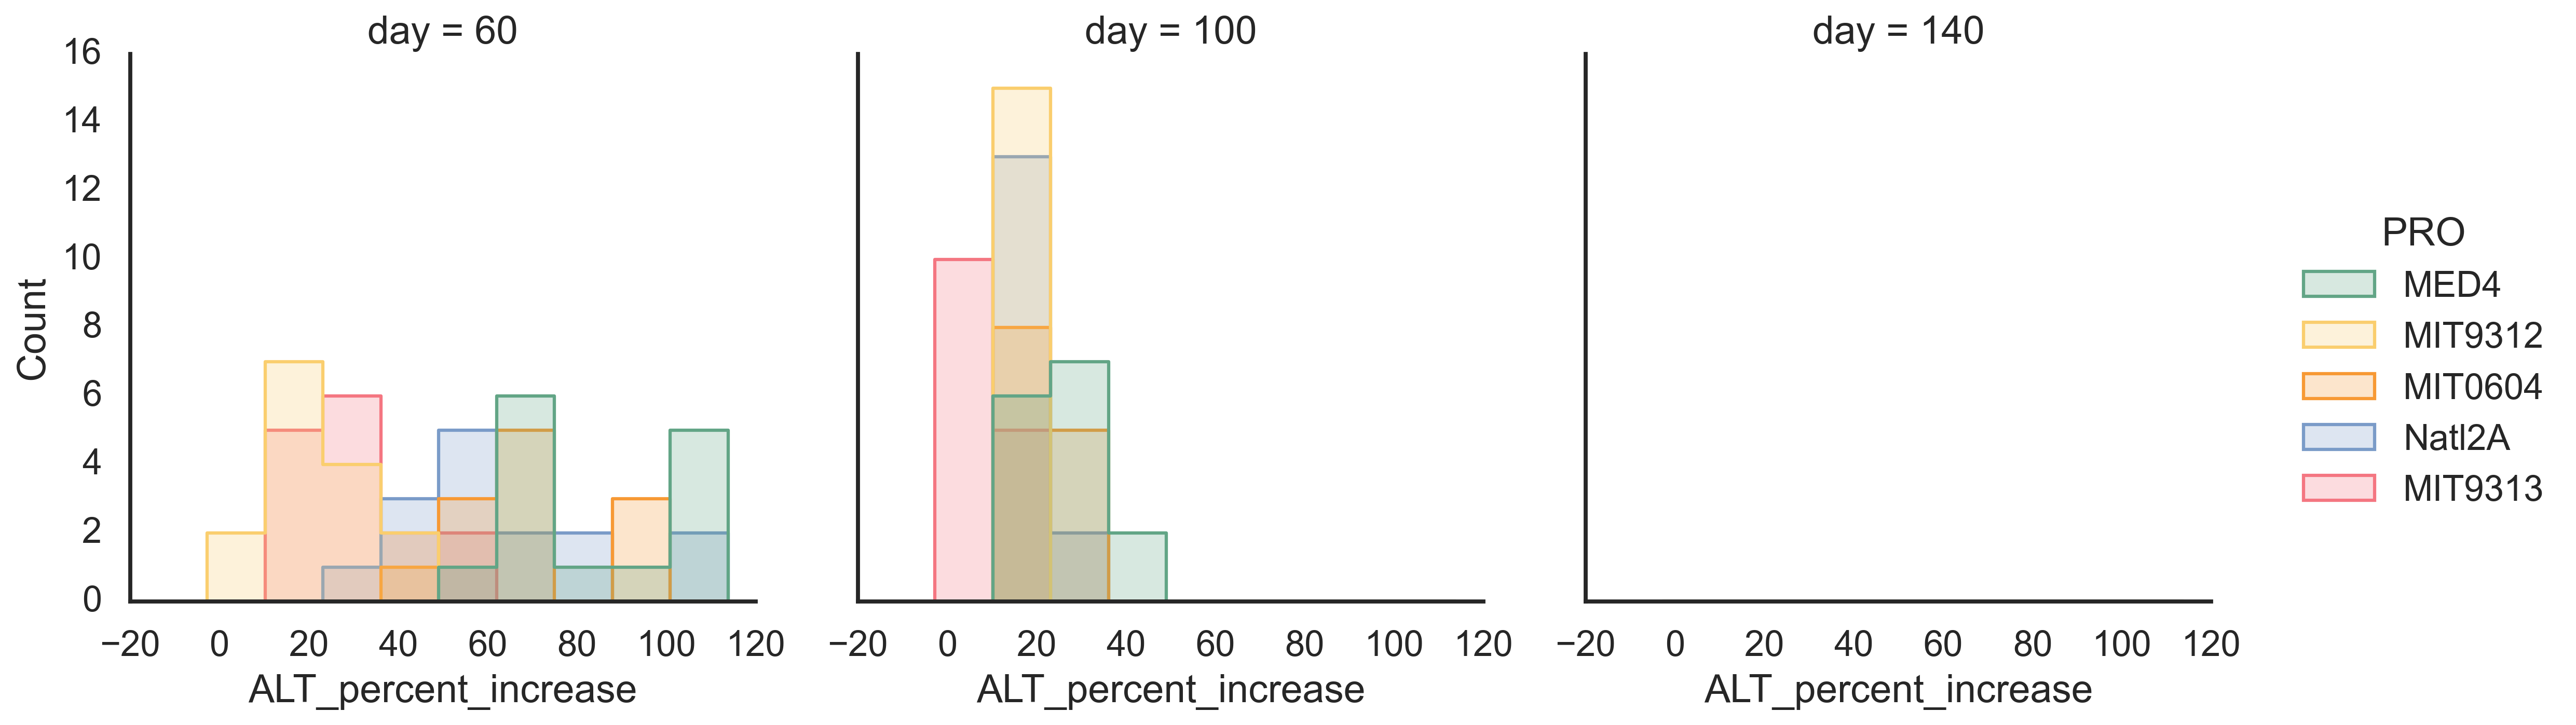

In [39]:
 sns.displot(
     data = df.loc[df.experiment.isin(['exp1']) & df.culture.isin(['Co_Culture'])], x='ALT_percent_increase',
     hue='PRO', palette=ppallete, hue_order=porder, col='day', element='step', #bins=1000
 )#.set(xlim=(-3,3))

In [40]:
df.loc[df.ALT_percent_increase < -2]

PRO  ALT sample        PRO.1         ALT.1 experiment  day  \
95      NaN   DE    32C          NaN  5.819593e+02       exp1  100   
37  MIT9312  DE1    13B  34301333.33  3.308259e+06       exp1   60   
95      NaN   DE    32C          NaN  2.385834e+05       exp1   60   

       culture         pair  C[PRO] min  ...  C[ALT] max  N[ALT] min  \
95    ALT Only           DE         NaN  ...    0.004268    0.000540   
37  Co_Culture  MIT9312,DE1   48.593556  ...   24.260568    3.071955   
95    ALT Only           DE         NaN  ...    1.749612    0.221542   

    N[ALT] max  C[Total] min  C[Total] max  N[Total] min  N[Total] max  \
95    0.001039      0.002716      0.004268      0.000540      0.001039   
37    5.907606     64.032099    167.182790     11.647288     30.408558   
95    0.426042      1.113389      1.749612      0.221542      0.426042   

    percent_N  percent_PRO  ALT_percent_increase  
95   0.000004          NaN          -1927.166126  
37   0.084053     0.736251             -2.755290  
95   0.001599          NaN           -168.481583  

[3 rows x 24 columns]

In [41]:
df.head()

PRO  ALT sample         PRO.1         ALT.1 experiment  day  \
0     MED4  1A3     1A  7.485642e+06  2.992351e+07       exp1  100   
1     MED4  1A3     1B  6.720907e+06  2.159764e+07       exp1  100   
2     MED4  1A3     1C  1.121335e+07  1.742056e+07       exp1  100   
3  MIT9313  1A3     2A  1.415617e+06  5.134250e+06       exp1  100   
4  MIT9313  1A3     2B  1.018640e+06  4.885134e+06       exp1  100   

      culture         pair  C[PRO] min  ...  C[ALT] max  N[ALT] min  \
0  Co_Culture     MED4,1A3   10.604660  ...  219.439074   27.786117   
1  Co_Culture     MED4,1A3    9.521285  ...  158.382711   20.054954   
2  Co_Culture     MED4,1A3   15.885579  ...  127.750797   16.176237   
3  Co_Culture  MIT9313,1A3    4.010915  ...   37.651168    4.767518   
4  Co_Culture  MIT9313,1A3    2.886146  ...   35.824318    4.536196   

   N[ALT] max  C[Total] min  C[Total] max  N[Total] min  N[Total] max  \
0   53.434840    150.247707    250.629251     29.657527     58.781727   
1   38.567219    110.310283    186.386490     21.735180     43.367866   
2   31.108149     97.181541    174.473089     18.979575     39.117684   
3    9.168304     27.970749     49.447977      5.475327     11.190614   
4    8.723454     25.683439     44.312983      5.045516     10.178654   

   percent_N  percent_PRO  ALT_percent_increase  
0   0.214023     0.063101             27.756630  
1   0.156852     0.077304             20.014100  
2   0.136966     0.147703             16.125588  
3   0.039513     0.129272              4.595663  
4   0.036411     0.100945              4.355577  

[5 rows x 24 columns]

In [42]:
c_cols = ['C[PRO] min', 'C[PRO] max',  'C[ALT] min', 'C[ALT] max','C[Total] min', 'C[Total] max']
n_cols = ['N[PRO] min', 'N[PRO] max',  'N[ALT] min', 'N[ALT] max','N[Total] min', 'N[Total] max']


In [43]:
df.groupby(['culture', 'day']).agg(['mean', 'std'])[c_cols]

C[PRO] min             C[PRO] max             C[ALT] min  \
                          mean        std        mean        std        mean   
culture    day                                                                 
ALT Only   60              NaN        NaN         NaN        NaN  160.778047   
           100             NaN        NaN         NaN        NaN   19.749787   
           140             NaN        NaN         NaN        NaN         NaN   
Co_Culture 60        44.067072  32.358019  129.609034  95.170646  270.070310   
           100       16.302167  11.368007   47.947550  33.435315   88.325220   
           140        1.350987   2.272258    3.973491   6.683111    4.221406   
           exp3_140   5.096183   6.379392   14.988772  18.762919   51.456854   
           exp4_140   0.477485   0.586826    1.404367   1.725958    3.884042   
PRO Only   60         0.050607   0.029166    0.148844   0.085783         NaN   
           100        0.286343   1.057919    0.842184   3.111527         NaN   
           140        0.000714   0.000564    0.002101   0.001660         NaN   

                                 C[ALT] max             C[Total] min  \
                            std        mean         std         mean   
culture    day                                                         
ALT Only   60        112.866086  252.651217  177.360992   160.778047   
           100        20.032645   31.035380   31.479870    19.749787   
           140              NaN         NaN         NaN          NaN   
Co_Culture 60        145.318370  424.396201  228.357439   314.343058   
           100        38.797468  138.796774   60.967450   104.627387   
           140         3.294574    6.633638    5.177188     5.562585   
           exp3_140   80.715061   80.860770  126.837953    56.690390   
           exp4_140    1.793980    6.103495    2.819111     4.361527   
PRO Only   60               NaN         NaN         NaN     0.050607   
           100              NaN         NaN         NaN     0.286343   
           140              NaN         NaN         NaN     0.000714   

                                C[Total] max              
                            std         mean         std  
culture    day                                            
ALT Only   60        112.866086   252.651217  177.360992  
           100        20.032645    31.035380   31.479870  
           140              NaN          NaN         NaN  
Co_Culture 60        159.369410   554.610165  276.157148  
           100        45.342217   186.744324   82.357690  
           140         4.394947    10.578282    9.326051  
           exp3_140   81.969996    96.253524  131.137625  
           exp4_140    1.923047     7.507862    3.398828  
PRO Only   60          0.029166     0.148844    0.085783  
           100         1.057919     0.842184    3.111527  
           140         0.000564     0.002101    0.001660

In [44]:
n_cols


['N[PRO] min',
 'N[PRO] max',
 'N[ALT] min',
 'N[ALT] max',
 'N[Total] min',
 'N[Total] max']

In [45]:
df.groupby(['culture', 'day']).agg(['mean', 'std'])[['N[Total] min',
 'N[Total] max']]

N[Total] min            N[Total] max           
                            mean        std         mean        std
culture    day                                                     
ALT Only   60          31.991550  22.458048    61.522212  43.188553
           100          3.929805   3.986087     7.557317   7.665553
           140               NaN        NaN          NaN        NaN
Co_Culture 60          61.551318  31.339454   125.665625  63.118305
           100         20.451769   8.855504    42.017496  18.291160
           140          1.076652   0.840293     2.291559   1.882083
           exp3_140    11.162429  16.277286    22.328880  31.557018
           exp4_140     0.857107   0.378024     1.726989   0.764792
PRO Only   60           0.008931   0.005147     0.025516   0.014706
           100          0.050531   0.186692     0.144374   0.533405
           140          0.000126   0.000100     0.000360   0.000285

In [46]:
df.groupby(['culture', 'day'])['percent_N'].describe()

count          mean           std           min  \
culture    day                                                         
ALT Only   60         15.0  2.308669e-01  1.620684e-01  1.598755e-03   
           100        13.0  2.835941e-02  2.876558e-02  3.899727e-06   
           140         0.0           NaN           NaN           NaN   
Co_Culture 60         71.0  4.441848e-01  2.261610e-01  8.405260e-02   
           100        73.0  1.475901e-01  6.390570e-02  3.187387e-02   
           140        72.0  7.769655e-03  6.063969e-03  5.257517e-06   
           exp3_140   73.0  8.055361e-02  1.174649e-01  7.351911e-05   
           exp4_140   75.0  6.185309e-03  2.728009e-03  1.370425e-06   
PRO Only   60         14.0  6.444797e-05  3.714311e-05  1.447495e-05   
           100        14.0  3.646571e-04  1.347259e-03  1.282552e-06   
           140        14.0  9.097938e-07  7.187889e-07  1.804124e-07   

                              25%           50%       75%       max  
culture    day                                                       
ALT Only   60        1.246716e-01  1.585890e-01  0.364385  0.562687  
           100       7.068255e-03  2.052036e-02  0.035096  0.091800  
           140                NaN           NaN       NaN       NaN  
Co_Culture 60        2.335282e-01  4.434820e-01  0.564723  1.036195  
           100       1.071268e-01  1.370939e-01  0.188376  0.335148  
           140       2.421641e-03  6.858731e-03  0.011980  0.023687  
           exp3_140  1.504072e-02  3.062747e-02  0.099278  0.728945  
           exp4_140  4.017454e-03  6.370816e-03  0.008042  0.011250  
PRO Only   60        3.608247e-05  5.957804e-05  0.000074  0.000139  
           100       3.099502e-06  4.275175e-06  0.000007  0.005046  
           140       4.059278e-07  6.494845e-07  0.000001  0.000003

In [47]:
df.groupby(['culture', 'day', 'PRO']).agg(['mean', 'std'])['percent_N']

mean           std
culture    day      PRO                                
Co_Culture 60       MED4     6.488435e-01  1.510532e-01
                    MIT0604  5.481273e-01  1.134469e-01
                    MIT9312  2.060295e-01  7.369870e-02
                    MIT9313  2.687826e-01  9.992503e-02
                    Natl2A   5.835734e-01  2.081644e-01
           100      MED4     2.194487e-01  5.933677e-02
                    MIT0604  1.686485e-01  4.241209e-02
                    MIT9312  1.127159e-01  1.322357e-02
                    MIT9313  7.121443e-02  2.351345e-02
                    Natl2A   1.687307e-01  3.516531e-02
           140      MED4     6.308078e-03  3.825266e-03
                    MIT0604  1.375986e-02  3.992312e-03
                    MIT9312  2.296242e-03  9.390510e-04
                    MIT9313  6.326776e-03  5.997256e-03
                    Natl2A   1.135536e-02  6.428902e-03
           exp3_140 MED4     3.950288e-02  5.153479e-02
                    MIT0604  1.969329e-01  2.262272e-01
                    MIT9312  7.364172e-02  6.500015e-02
                    MIT9313  3.978500e-02  2.850611e-02
                    Natl2A   6.842279e-02  5.503058e-02
           exp4_140 MED4     7.713317e-03  2.429445e-03
                    MIT0604  4.790367e-03  2.603629e-03
                    MIT9312  5.708402e-03  1.491950e-03
                    MIT9313  4.317715e-03  2.737835e-03
                    Natl2A   8.396745e-03  1.768272e-03
PRO Only   60       MED4     2.964916e-05  4.678339e-06
                    MIT0604  5.412371e-05  1.305376e-05
                    MIT9312  5.803964e-05  5.394834e-06
                    MIT9313  1.239111e-04  1.473459e-05
                    Natl2A   5.307480e-05  3.364105e-05
           100      MED4     1.852576e-06  4.936546e-07
                    MIT0604  3.847657e-06  6.046010e-07
                    MIT9312  3.705151e-06  6.530437e-07
                    MIT9313  7.695314e-06  2.262210e-06
                    Natl2A   1.685915e-03  2.909539e-03
           140      MED4     1.443299e-06  1.256686e-06
                    MIT0604  6.855670e-07  4.592549e-07
                    MIT9312  3.006873e-07  1.102338e-07
                    MIT9313  6.013746e-07  1.666578e-07
                    Natl2A   1.443299e-06  1.739834e-07

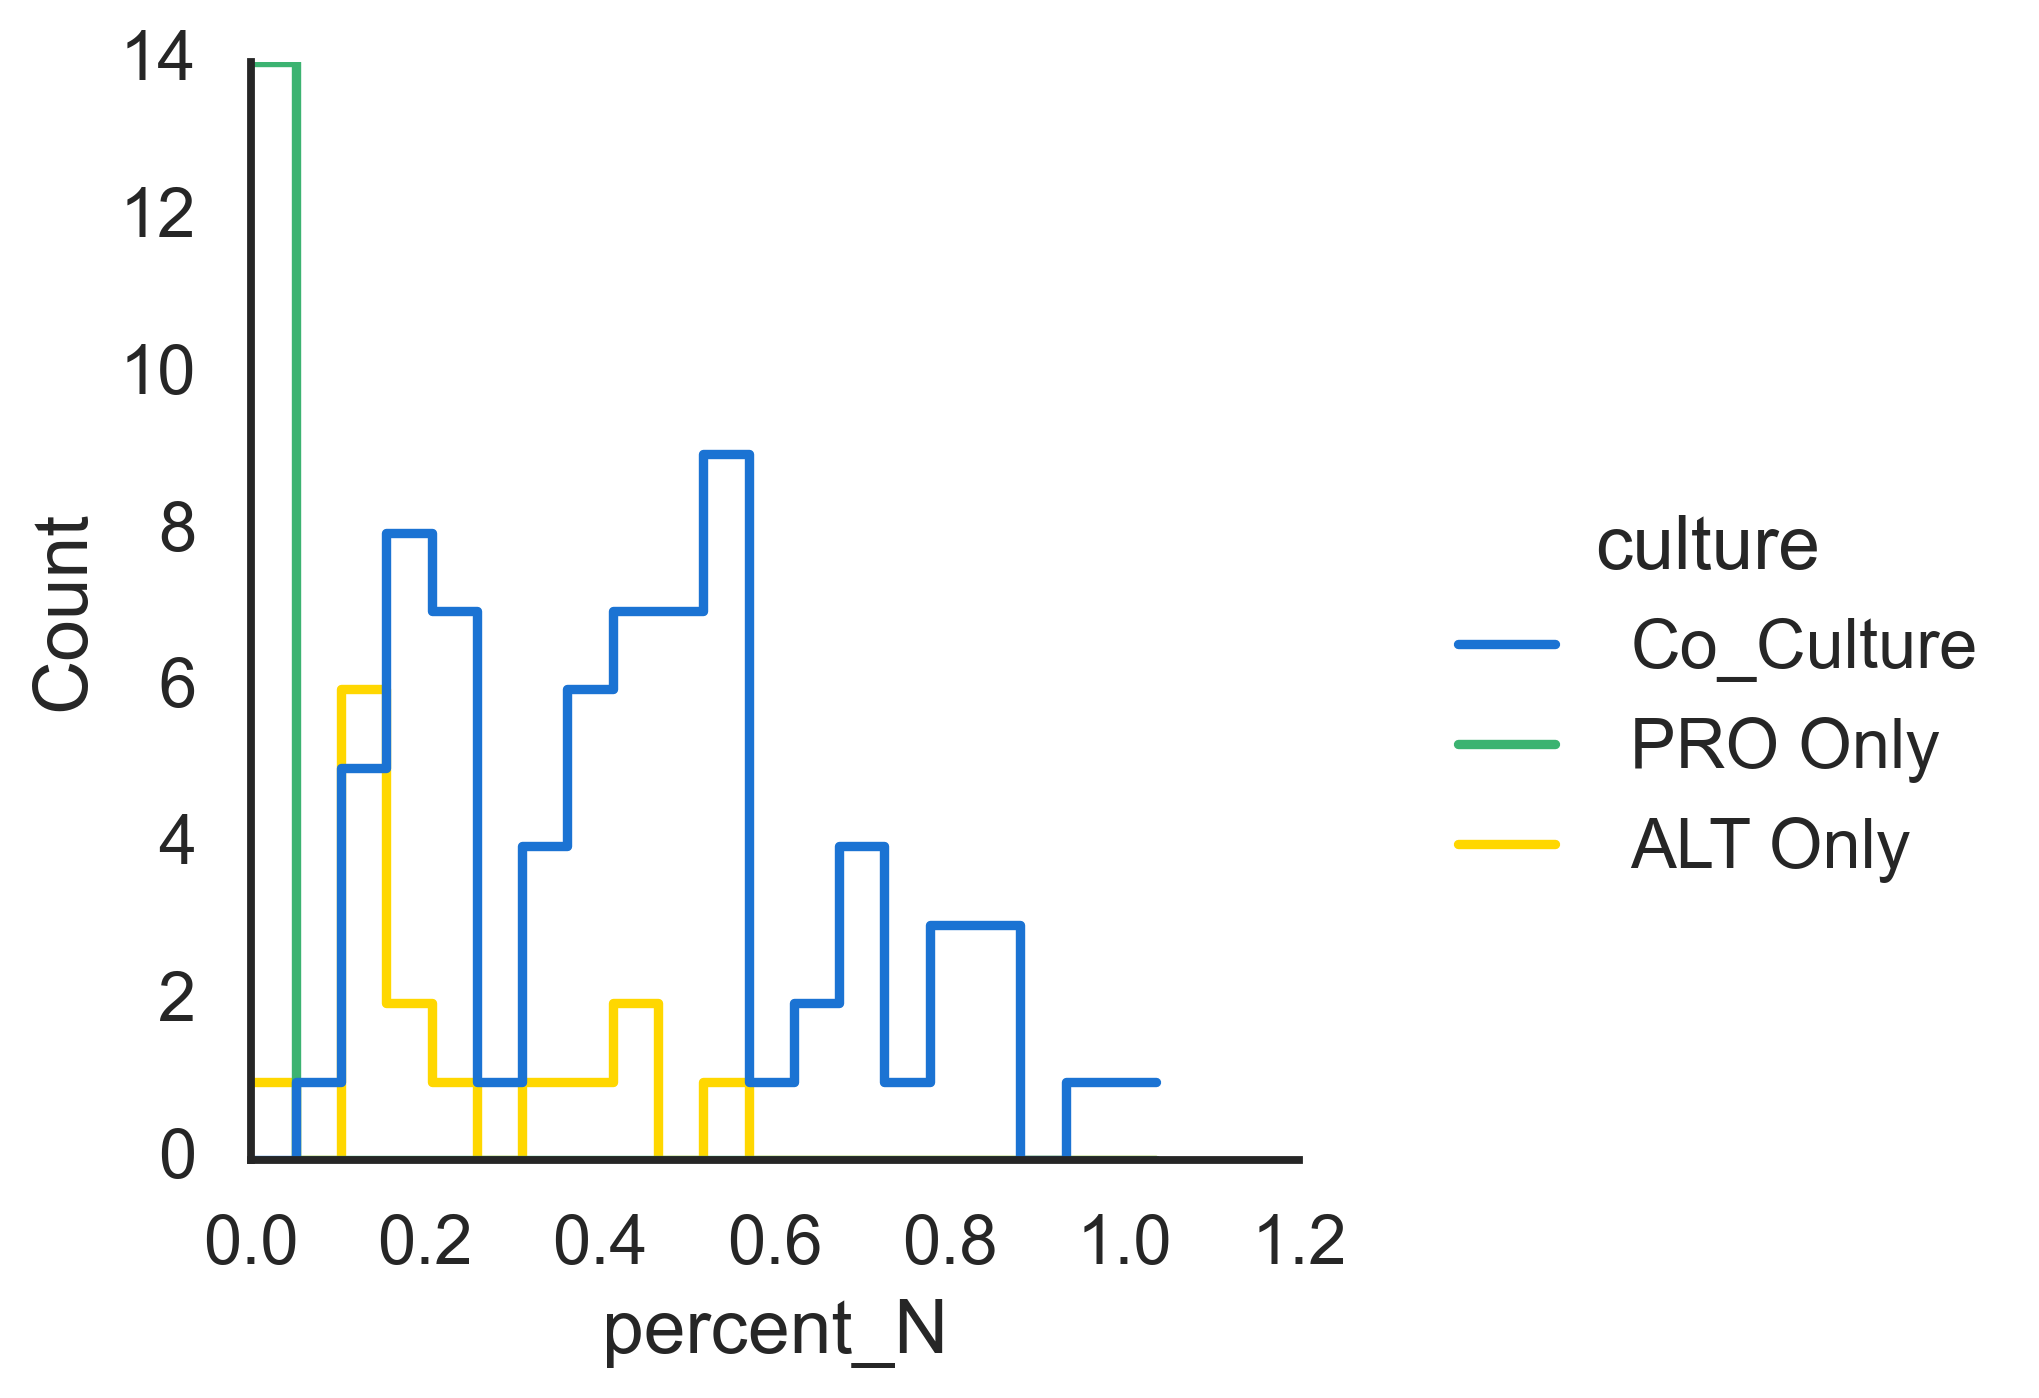

In [48]:
sns.displot(data = df.loc[df.day == 60],
            hue='culture', x='percent_N',  element="step", bins=20,
                       palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], 
            hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],
            fill=False,
)

In [49]:
df.groupby(['culture', 'day']).agg(['mean', 'std'])[['N[ALT] min',
 'N[ALT] max']]

N[ALT] min             N[ALT] max           
                          mean        std        mean        std
culture    day                                                  
ALT Only   60        31.991550  22.458048   61.522212  43.188553
           100        3.929805   3.986087    7.557317   7.665553
           140             NaN        NaN         NaN        NaN
Co_Culture 60        53.738480  28.915390  103.343231  55.606519
           100       17.574916   7.719904   33.797916  14.845970
           140        0.839974   0.655553    1.615334   1.260679
           exp3_140  10.238864  16.060650   19.690123  30.885865
           exp4_140   0.772845   0.356965    1.486241   0.686472
PRO Only   60              NaN        NaN         NaN        NaN
           100             NaN        NaN         NaN        NaN
           140             NaN        NaN         NaN        NaN

In [50]:
df.groupby(['culture', 'day']).agg(['mean', 'std'])[['N[PRO] min',
 'N[PRO] max']]

N[PRO] min           N[PRO] max           
                          mean       std       mean        std
culture    day                                                
ALT Only   60              NaN       NaN        NaN        NaN
           100             NaN       NaN        NaN        NaN
           140             NaN       NaN        NaN        NaN
Co_Culture 60         7.776542  5.710239  22.218692  16.314968
           100        2.876853  2.006119   8.219580   5.731768
           140        0.238409  0.400987   0.681170   1.145676
           exp3_140   0.899326  1.125775   2.569504   3.216500
           exp4_140   0.084262  0.103557   0.240749   0.295879
PRO Only   60         0.008931  0.005147   0.025516   0.014706
           100        0.050531  0.186692   0.144374   0.533405
           140        0.000126  0.000100   0.000360   0.000285

In [51]:
df.groupby(['culture', 'day']).agg(['mean', 'std', 'count'])[['C[Total] min',
 'C[Total] max']]

C[Total] min                   C[Total] max              \
                            mean         std count         mean         std   
culture    day                                                                
ALT Only   60         160.778047  112.866086    15   252.651217  177.360992   
           100         19.749787   20.032645    13    31.035380   31.479870   
           140               NaN         NaN     0          NaN         NaN   
Co_Culture 60         314.343058  159.369410    71   554.610165  276.157148   
           100        104.627387   45.342217    73   186.744324   82.357690   
           140          5.562585    4.394947    72    10.578282    9.326051   
           exp3_140    56.690390   81.969996    73    96.253524  131.137625   
           exp4_140     4.361527    1.923047    75     7.507862    3.398828   
PRO Only   60           0.050607    0.029166    14     0.148844    0.085783   
           100          0.286343    1.057919    14     0.842184    3.111527   
           140          0.000714    0.000564    14     0.002101    0.001660   

                           
                    count  
culture    day             
ALT Only   60          15  
           100         13  
           140          0  
Co_Culture 60          71  
           100         73  
           140         72  
           exp3_140    73  
           exp4_140    75  
PRO Only   60          14  
           100         14  
           140         14

In [52]:
df.loc[df['culture'].isin(['Co_Culture']) & (df.day == 140)]['experiment'].value_counts()

exp1    73
Name: experiment, dtype: int64

In [53]:
df.groupby(['culture', 'day']).agg(['mean', 'std'])[['C[ALT] min',
 'C[ALT] max']]

C[ALT] min              C[ALT] max            
                           mean         std        mean         std
culture    day                                                     
ALT Only   60        160.778047  112.866086  252.651217  177.360992
           100        19.749787   20.032645   31.035380   31.479870
           140              NaN         NaN         NaN         NaN
Co_Culture 60        270.070310  145.318370  424.396201  228.357439
           100        88.325220   38.797468  138.796774   60.967450
           140         4.221406    3.294574    6.633638    5.177188
           exp3_140   51.456854   80.715061   80.860770  126.837953
           exp4_140    3.884042    1.793980    6.103495    2.819111
PRO Only   60               NaN         NaN         NaN         NaN
           100              NaN         NaN         NaN         NaN
           140              NaN         NaN         NaN         NaN

In [54]:
df.groupby(['culture', 'day']).agg(['mean', 'std', 'count'])[['C[PRO] min',
 'C[PRO] max']]

C[PRO] min                   C[PRO] max                 
                          mean        std count        mean        std count
culture    day                                                              
ALT Only   60              NaN        NaN     0         NaN        NaN     0
           100             NaN        NaN     0         NaN        NaN     0
           140             NaN        NaN     0         NaN        NaN     0
Co_Culture 60        44.067072  32.358019    73  129.609034  95.170646    73
           100       16.302167  11.368007    73   47.947550  33.435315    73
           140        1.350987   2.272258    73    3.973491   6.683111    73
           exp3_140   5.096183   6.379392    75   14.988772  18.762919    75
           exp4_140   0.477485   0.586826    75    1.404367   1.725958    75
PRO Only   60         0.050607   0.029166    14    0.148844   0.085783    14
           100        0.286343   1.057919    14    0.842184   3.111527    14
           140        0.000714   0.000564    14    0.002101   0.001660    14

In [55]:
df.groupby(['culture', 'day']).agg(['mean', 'std'])[['PRO.1',
 'ALT.1']]

PRO.1                       ALT.1              
                             mean           std          mean           std
culture    day                                                             
ALT Only   60                 NaN           NaN  3.445244e+07  2.418559e+07
           100                NaN           NaN  4.232097e+06  4.292710e+06
           140                NaN           NaN           NaN           NaN
Co_Culture 60        2.412798e+07  1.426467e+07  5.787221e+07  3.113965e+07
           100       9.816660e+06  6.614922e+06  1.892683e+07  8.313743e+06
           140       8.062954e+05  1.452527e+06  9.045870e+05  7.059802e+05
           exp3_140  2.963316e+06  4.173221e+06  1.102647e+07  1.729608e+07
           exp4_140  3.303532e+05  4.184154e+05  8.322947e+05  3.844242e+05
PRO Only   60        2.626246e+04  9.515213e+03           NaN           NaN
           100       1.349188e+05  4.977951e+05           NaN           NaN
           140       4.114286e+02  3.837238e+02           NaN           NaN

In [56]:
mdf = df.loc[df.experiment.isin(['exp1'])].melt(
    id_vars=['PRO', 'ALT', 'sample', 'day', 'culture', 'experiment', 'pair']
    
)

In [57]:
df.columns

Index(['PRO', 'ALT', 'sample', 'PRO.1', 'ALT.1', 'experiment', 'day',
       'culture', 'pair', 'C[PRO] min', 'C[PRO] max', 'N[PRO] min',
       'N[PRO] max', 'C[ALT] min', 'C[ALT] max', 'N[ALT] min', 'N[ALT] max',
       'C[Total] min', 'C[Total] max', 'N[Total] min', 'N[Total] max',
       'percent_N', 'percent_PRO', 'ALT_percent_increase'],
      dtype='object')

In [58]:
df = df.fillna({'PRO': 'Axenic', 'ALT': 'Axenic'})


In [59]:
df.loc[df.PRO.isin(['Axenic']), 'PRO'] = 'ALT Only'
df.loc[df.ALT.isin(['Axenic']), 'ALT'] = 'PRO Only'


In [60]:
mdf.loc[mdf.PRO.isna(), 'PRO'] = 'ALT Only'
mdf.loc[mdf.ALT.isna(), 'ALT'] = 'PRO Only'


In [61]:
c_cols

['C[PRO] min',
 'C[PRO] max',
 'C[ALT] min',
 'C[ALT] max',
 'C[Total] min',
 'C[Total] max']

In [62]:
mdf.loc[mdf.variable.isin(['C[PRO] min', 'C[PRO] max','N[PRO] min', 'N[PRO] max',]), 'biomass of'] = 'PRO'
mdf.loc[mdf.variable.isin(['C[ALT] min', 'C[ALT] max','N[ALT] min', 'N[ALT] max',]), 'biomass of'] = 'ALT'
mdf.loc[mdf.variable.isin(['C[Total] min', 'C[Total] max','N[Total] min', 'N[Total] max',]), 'biomass of'] = 'Total'

In [63]:
mdf.loc[mdf['biomass of'].isin(['PRO']) & mdf.culture.isin(['PRO Only']), 'biomass of'] = 'PRO Only'
mdf.loc[mdf['biomass of'].isin(['ALT']) & mdf.culture.isin(['ALT Only']), 'biomass of'] = 'ALT Only'


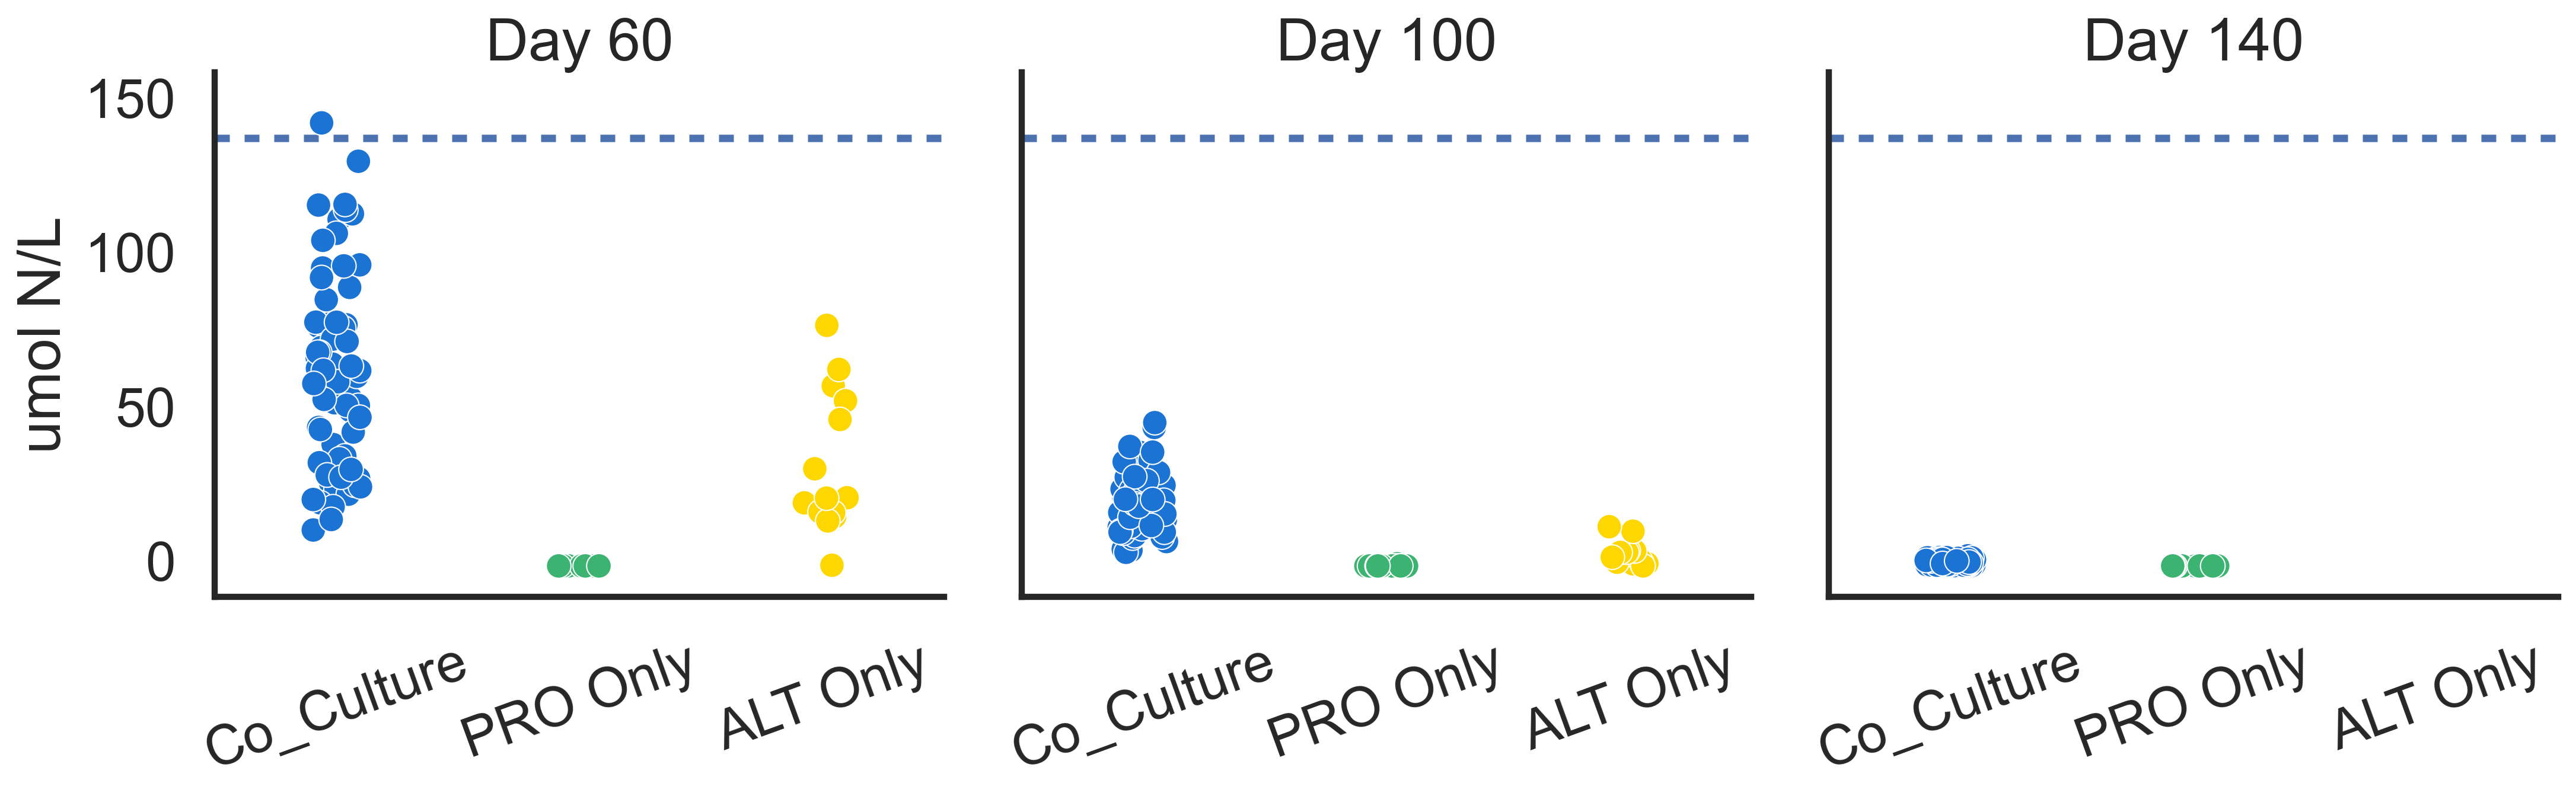

In [64]:

sns.set_context('poster')
g = sns.catplot(data=mdf.loc[mdf.variable.isin(['N[Total] min', #'N[Total] max'
                                               ])],
            hue='culture', y='value', #hue='culture', 
            col='day',x='culture',
            #kind='box', 
            #kind='box',
            #order=porder + ['ALT Only'],
            palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],
            order=['Co_Culture', 'PRO Only', 'ALT Only', ],
            #hue_order=porder + ['ALT Only'],
            #palette=ppallete + ['grey'], 
            dodge=False,
                edgecolor='white', linewidth=0.5,
            #sharey=False, #
                s=10, 
           ).set(#ylabel='umol N/L', 
                 xlabel='', 
                 ylim=(-10, 160), yticks=(0,50,100,150)
                 #yscale='log'
                ).set_xticklabels(rotation=20).set_titles('Day {col_name}')
g.axes.flat[0].set(ylabel='umol N/L')
plt.tight_layout()
for ax in g.axes.flat:
    ax.axhline(initial_N_max, ls='--')

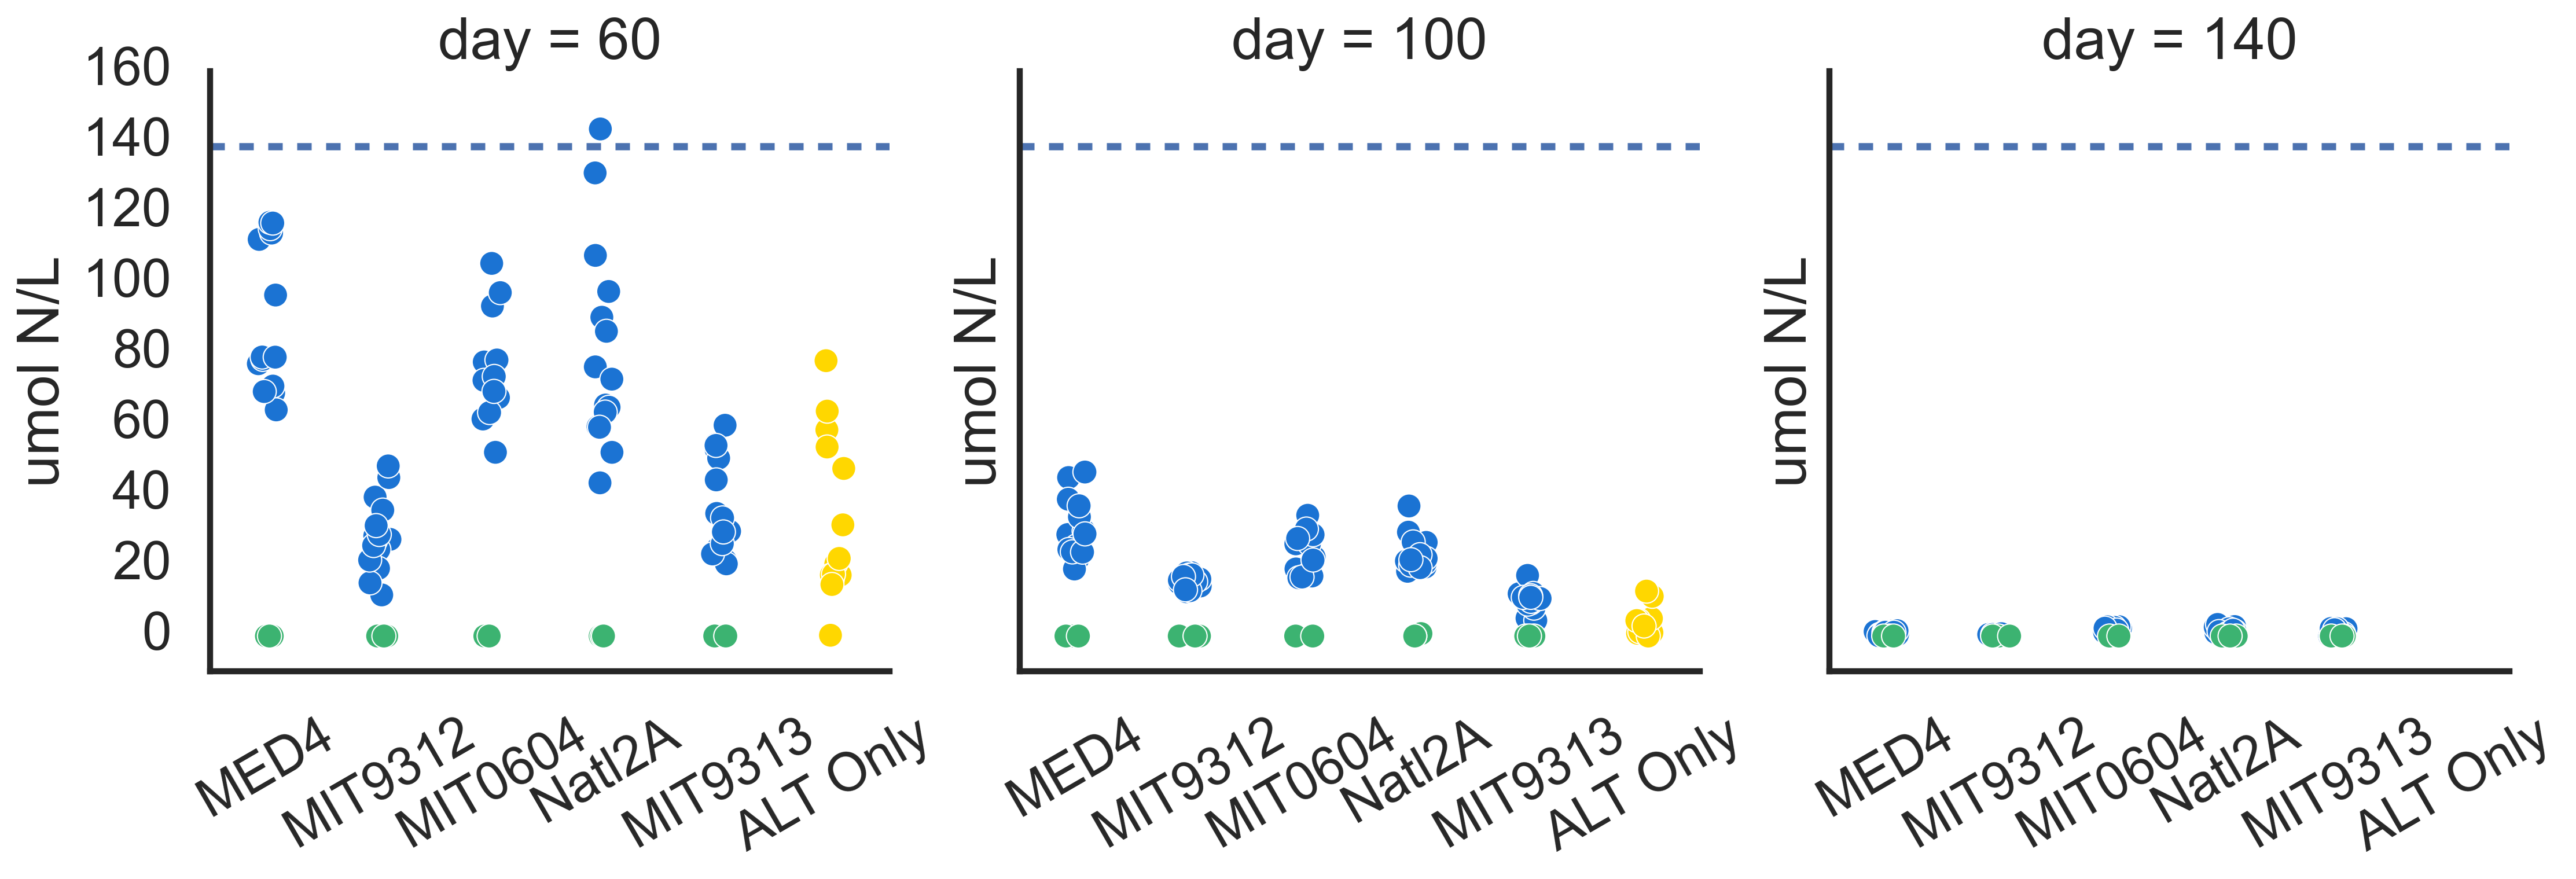

In [65]:

g = sns.catplot(data=mdf.loc[mdf.variable.isin(['N[Total] min', #'N[Total] max'
                                               ])],
            hue='culture', y='value', #hue='culture', 
            col='day',x='PRO',
            #kind='box', 
            #kind='box',
            order=porder + ['ALT Only'],
            palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],

            #hue_order=porder + ['ALT Only'],
            #palette=ppallete + ['grey'], 
                edgecolor='white', linewidth=0.5,
            dodge=False,
                legend=False,
            #sharey=False, #
                s=10, 
           ).set(ylabel='umol N/L', xlabel='', 
                 ylim=(-10, 160)
                 #yscale='log'
                ).set_xticklabels(rotation=30) 
for ax in g.axes.flat:
    ax.axhline(initial_N_max, ls='--', label='Total N in media')

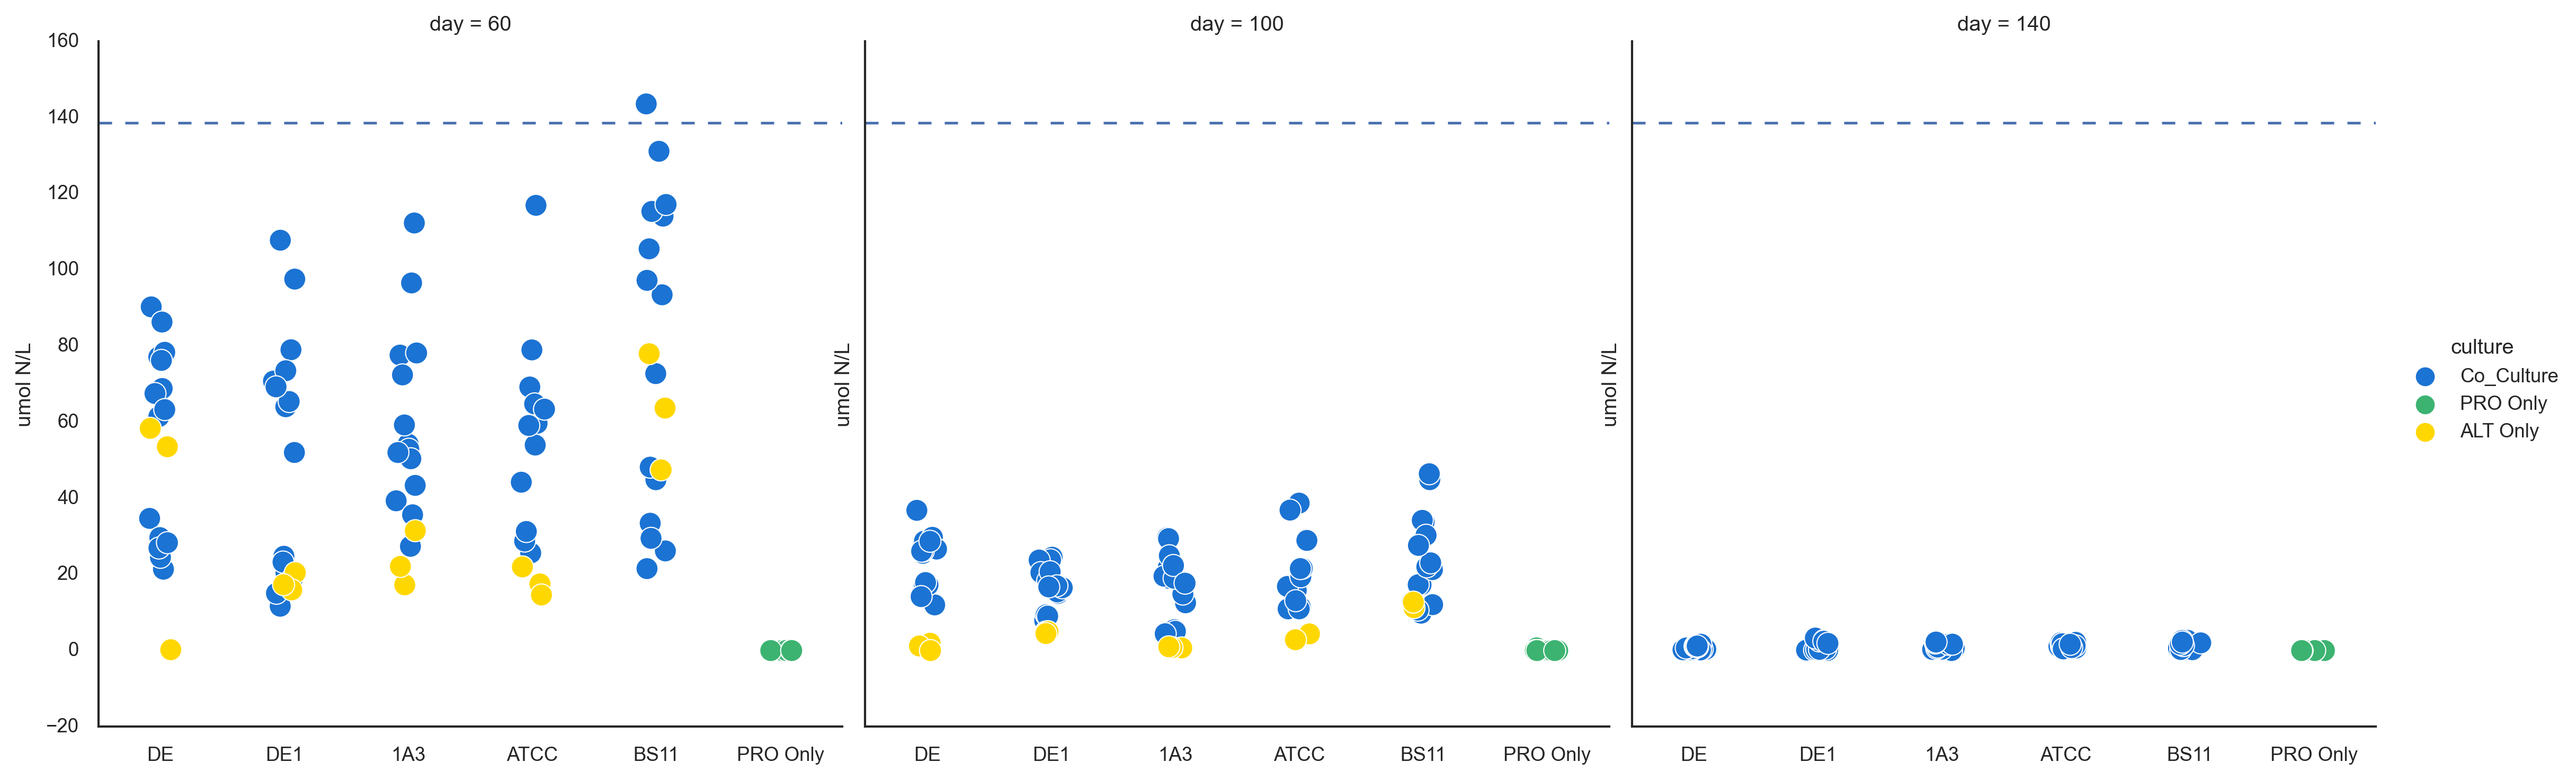

In [66]:

sns.set_context('paper')
g = sns.catplot(data=mdf.loc[mdf.variable.isin(['N[Total] min', #'N[Total] max'
                                               ])],
            hue='culture', y='value', #hue='culture', 
            col='day',x='ALT',
            #kind='box', 
            #kind='box',
            order=aorder + ['PRO Only'],
            palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],

            #hue_order=porder + ['ALT Only'],
            #palette=ppallete + ['grey'], 
                edgecolor='white', linewidth=0.5,
            dodge=False,
            #sharey=False, 
                s=10, 
           ).set(ylabel='umol N/L', xlabel='', 
                 #ylim=(-200, 2500)
                 #yscale='log'
                )
for ax in g.axes.flat:
    ax.axhline(initial_N_max, ls='--', label='Total N in media')

In [67]:
initial_N_max

138.57142857142858

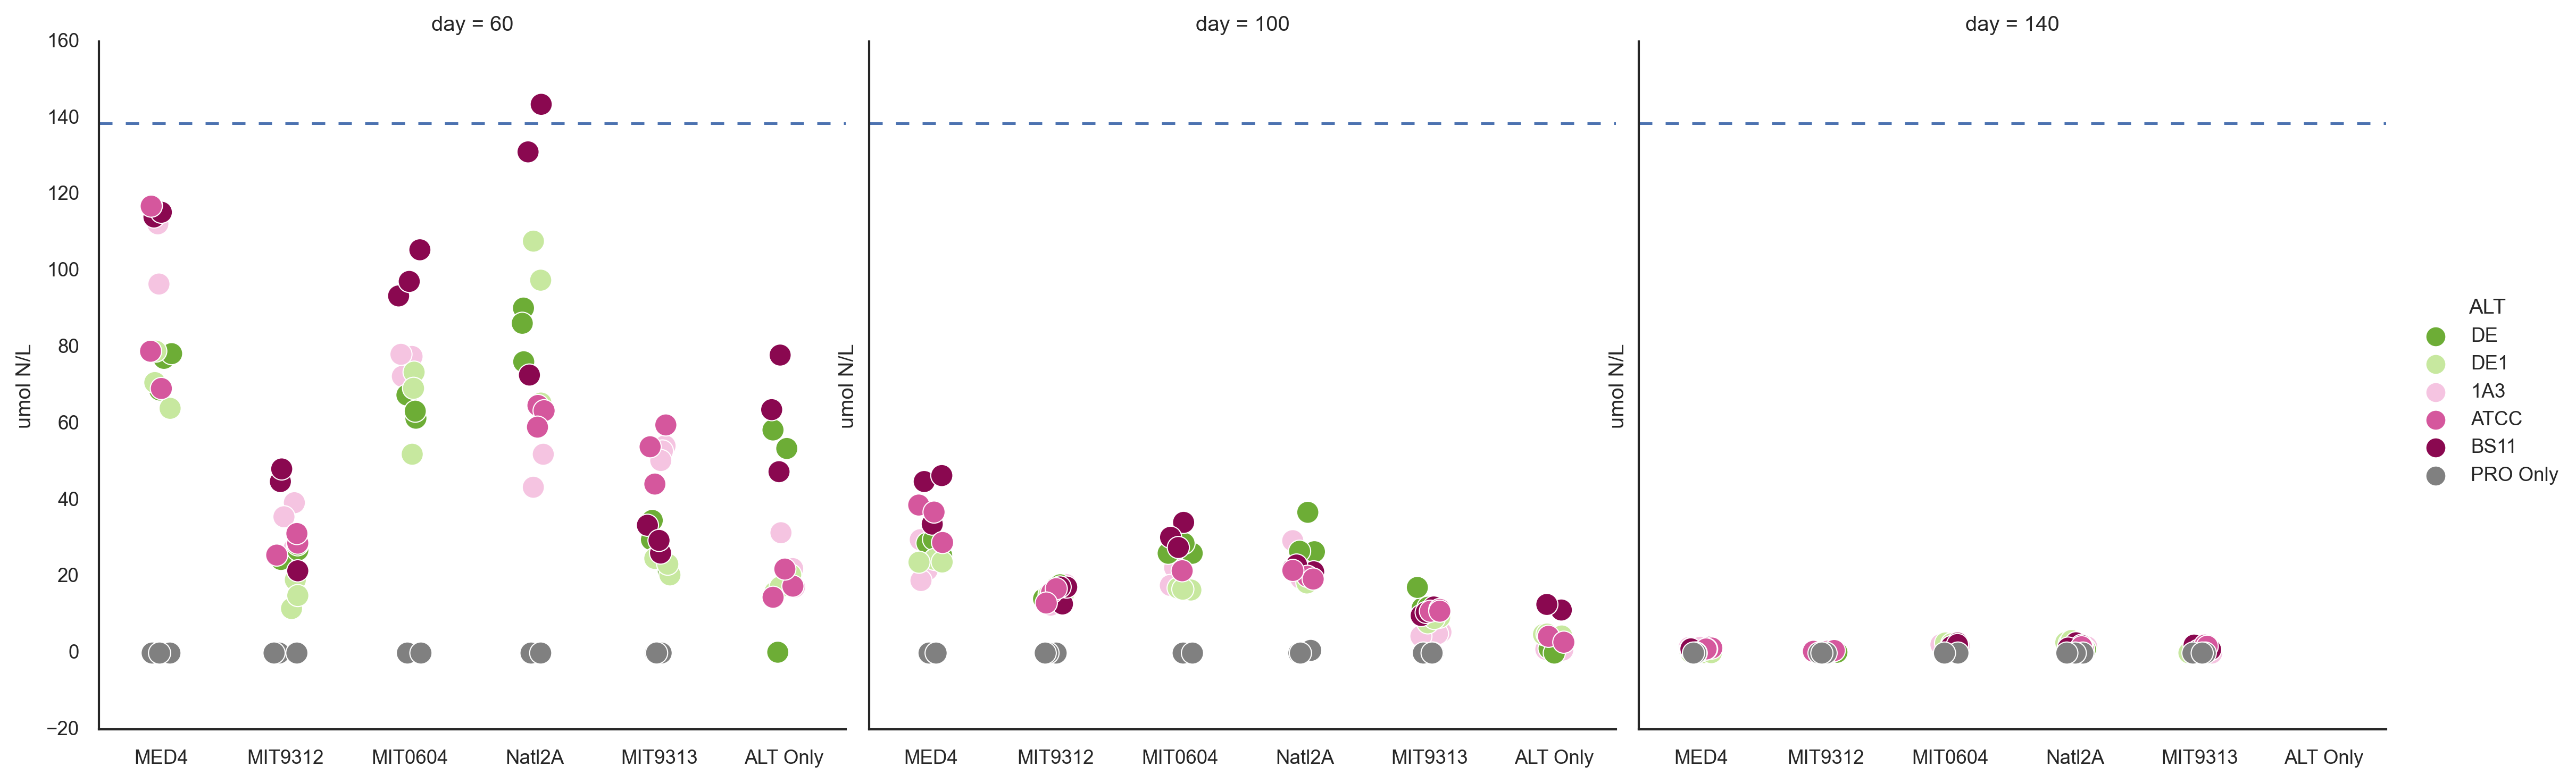

In [68]:

sns.set_context('paper')
g = sns.catplot(data=mdf.loc[mdf.variable.isin(['N[Total] min', #'N[Total] max'
                                               ])],
            hue='ALT', y='value', #hue='culture', 
            col='day',x='PRO',
            #kind='box', 
            #kind='swarm',
            order=porder + ['ALT Only'],
            #palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],

            hue_order=aorder + ['PRO Only'],
            palette=apallete + ['grey'], 
            dodge=False,
            #sharey=False,
                s=10, 
                edgecolor='white', linewidth=0.5,
           ).set(ylabel='umol N/L', xlabel='', 
                 #ylim=(-200, 2500)
                 #yscale='log'
                )
for ax in g.axes.flat:
    ax.axhline(initial_N_max, ls='--', label='Total N in media')

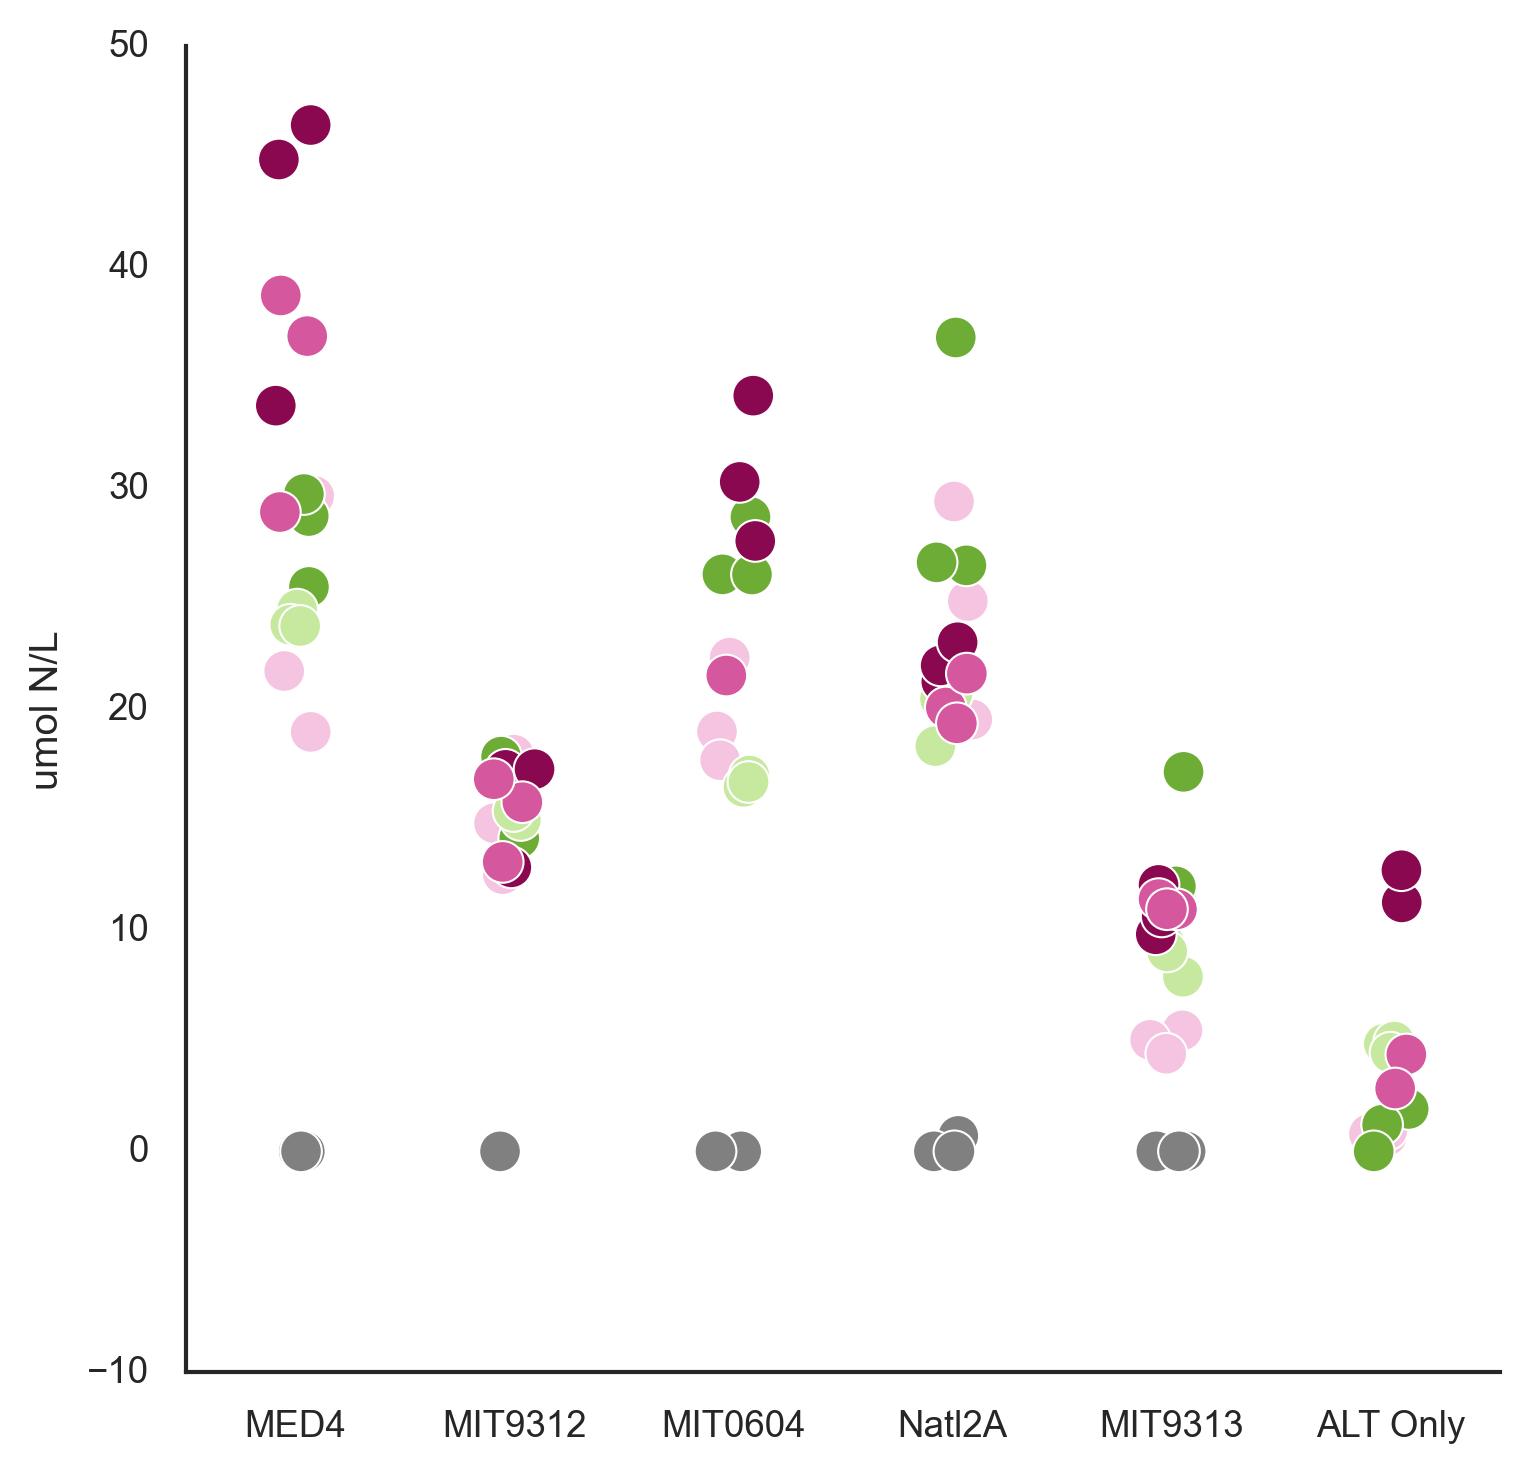

In [69]:

sns.set_context('paper')
g = sns.catplot(data=mdf.loc[mdf.variable.isin(['N[Total] min', #'N[Total] max'
                                               ]) &
                             (mdf.day == 100)
                                               ],
            hue='ALT', y='value', #hue='culture', 
            x='PRO',
            #kind='box', 
            #kind='swarm',
            order=porder + ['ALT Only'],
            #palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],

            hue_order=aorder + ['PRO Only'],
            palette=apallete + ['grey'], 
            dodge=False,
            sharey=False,
                s=10,
                edgecolor='white', linewidth=0.5,
                legend=False,
           ).set(ylabel='umol N/L', xlabel='', 
                 #ylim=(-200, 2500)
                 #yscale='log'
                )
#for ax in g.axes.flat:
#    ax.axhline(initial_N_max, ls='--', label='Total N in media')

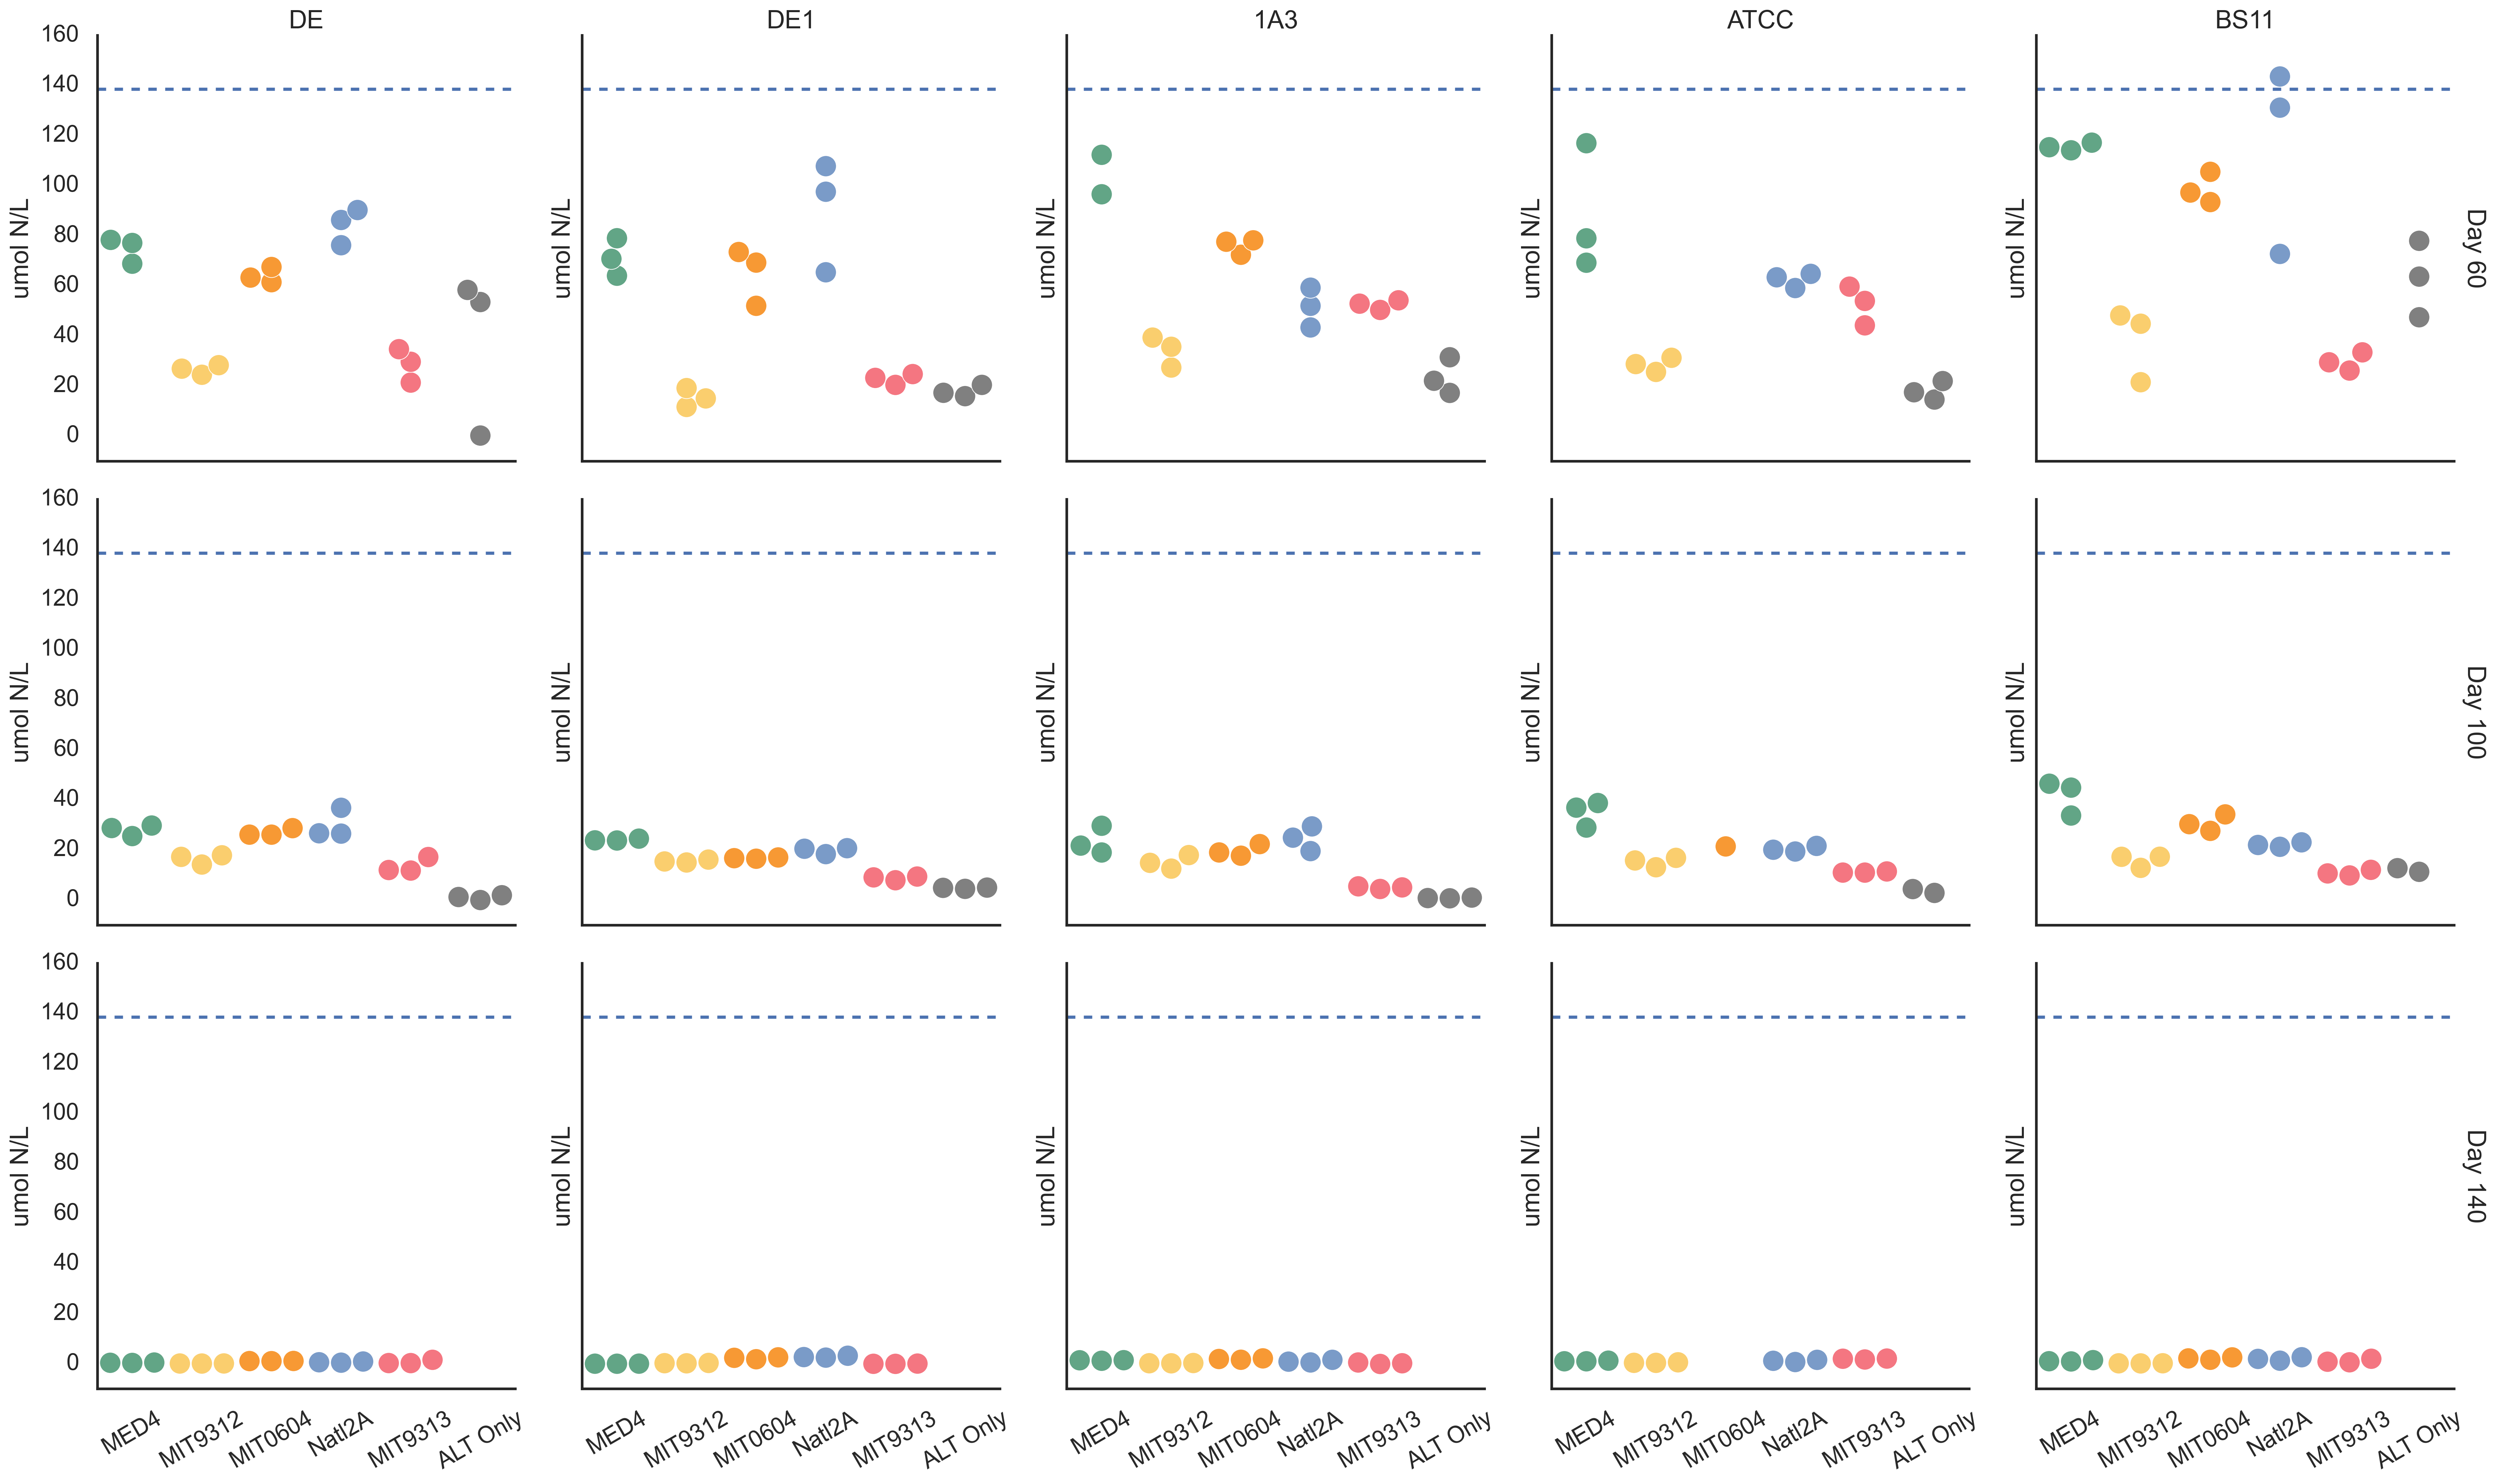

In [70]:
sns.set_context('talk')
g = sns.catplot(data=mdf.loc[mdf.variable.isin(['N[Total] min', #'N[Total] max'
                                               ]) ],
            hue='PRO', y='value', #hue='culture', 
            col='ALT', col_order=aorder, 
                row='day',x='PRO',
            #kind='box', 
            kind='swarm',
            order=porder + ['ALT Only'],
            #palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],

            hue_order=porder + ['ALT Only'],
            palette=ppallete + ['grey'], 
            #dodge=True,
            #sharey=False,
                edgecolor='white', linewidth=0.5,
                s=15, 
                legend=False, margin_titles=True,
           ).set(ylabel='umol N/L', xlabel='', 
                 ylim=(-10, 160), 
                 #yscale='log'
                ).set_xticklabels(rotation=30).set_titles(col_template="{col_name}", row_template="Day {row_name}")
          
plt.tight_layout()
for ax in g.axes.flat:
    ax.axhline(initial_N_max, ls='--', label='Total N in media')
plt.show()

In [71]:
df.loc[(df.day == 60) & df.ALT.isin(['DE'])]

PRO ALT sample         PRO.1         ALT.1 experiment day  \
15      MED4  DE     6A  1.456221e+07  7.021021e+07       exp1  60   
16      MED4  DE     6B  1.398733e+07  7.927801e+07       exp1  60   
17      MED4  DE     6C  1.757373e+07  7.963864e+07       exp1  60   
18   MIT9313  DE     7A  5.753456e+06  1.991616e+07       exp1  60   
19   MIT9313  DE     7B  6.023963e+06  3.413973e+07       exp1  60   
20   MIT9313  DE     7C  6.305530e+06  2.856233e+07       exp1  60   
21   MIT9312  DE     8A  1.504931e+07  2.232588e+07       exp1  60   
22   MIT9312  DE     8B  1.526406e+07  2.489648e+07       exp1  60   
23   MIT9312  DE     8C  1.622212e+07  2.614022e+07       exp1  60   
24    Natl2A  DE     9A  4.849539e+07  7.763038e+07       exp1  60   
25    Natl2A  DE     9B  4.767880e+07  7.367509e+07       exp1  60   
26    Natl2A  DE     9C  4.199355e+07  6.512053e+07       exp1  60   
27   MIT0604  DE    10A  2.120207e+07  6.047290e+07       exp1  60   
28   MIT0604  DE    10B  2.412512e+07  6.621555e+07       exp1  60   
29   MIT0604  DE    10C  2.090645e+07  6.253196e+07       exp1  60   
93  ALT Only  DE    32A           NaN  6.286300e+07       exp1  60   
94  ALT Only  DE    32B           NaN  5.764772e+07       exp1  60   
95  ALT Only  DE    32C           NaN  2.385834e+05       exp1  60   

       culture        pair  C[PRO] min  ...  C[ALT] max  N[ALT] min  \
15  Co_Culture     MED4,DE   20.629800  ...  514.874848   65.195192   
16  Co_Culture     MED4,DE   19.815380  ...  581.372053   73.615292   
17  Co_Culture     MED4,DE   24.896121  ...  584.016687   73.950165   
18  Co_Culture  MIT9313,DE   16.301459  ...  146.051843   18.493578   
19  Co_Culture  MIT9313,DE   17.067896  ...  250.358040   31.701180   
20  Co_Culture  MIT9313,DE   17.865668  ...  209.457108   26.522166   
21  Co_Culture  MIT9312,DE   21.319854  ...  163.723127   20.731175   
22  Co_Culture  MIT9312,DE   21.624078  ...  182.574160   23.118157   
23  Co_Culture  MIT9312,DE   22.981336  ...  191.694937   24.273060   
24  Co_Culture   Natl2A,DE  103.052707  ...  569.289429   72.085350   
25  Co_Culture   Natl2A,DE  101.317454  ...  540.284002   68.412585   
26  Co_Culture   Natl2A,DE   89.236290  ...  477.550587   60.469068   
27  Co_Culture  MIT0604,DE   30.036271  ...  443.467963   56.153411   
28  Co_Culture  MIT0604,DE   34.177247  ...  485.580721   61.485871   
29  Co_Culture  MIT0604,DE   29.617473  ...  458.567679   58.065388   
93    ALT Only          DE         NaN  ...  460.995340   58.372787   
94    ALT Only          DE         NaN  ...  422.749922   53.530023   
95    ALT Only          DE         NaN  ...    1.749612    0.221542   

    N[ALT] max  C[Total] min  C[Total] max  N[Total] min  N[Total] max  \
15  125.375369    348.277431    575.550731     68.835745    135.776949   
16  141.567870    389.779414    639.652583     77.112124    151.558818   
17  142.211856    396.543104    657.240573     78.343598    154.764522   
18   35.564572    109.243541    193.997311     21.370306     43.783795   
19   60.963808    176.386648    300.557733     34.713162     69.569470   
20   51.004166    151.156555    262.003191     29.674931     60.012066   
21   39.867644    125.507298    226.428580     24.493502     50.617151   
22   44.457993    137.807634    246.174390     26.934170     55.360890   
23   46.678962    144.969024    259.287103     28.328590     58.266190   
24  138.625673    465.327799    872.385627     90.271122    190.585021   
25  131.562663    445.134546    838.276513     86.292135    182.647093   
26  116.286669    393.132119    740.010265     76.216649    161.279757   
27  107.987329    312.243156    531.809937     61.453929    123.131667   
28  118.242059    343.183160    586.102034     67.517149    135.474284   
29  111.664208    321.433269    545.677894     63.292001    126.597387   
93  112.255359    293.360671    460.995340     58.372787    112.255359   
94  102.942351    269.022678    422.749922     53.530023    102.942351

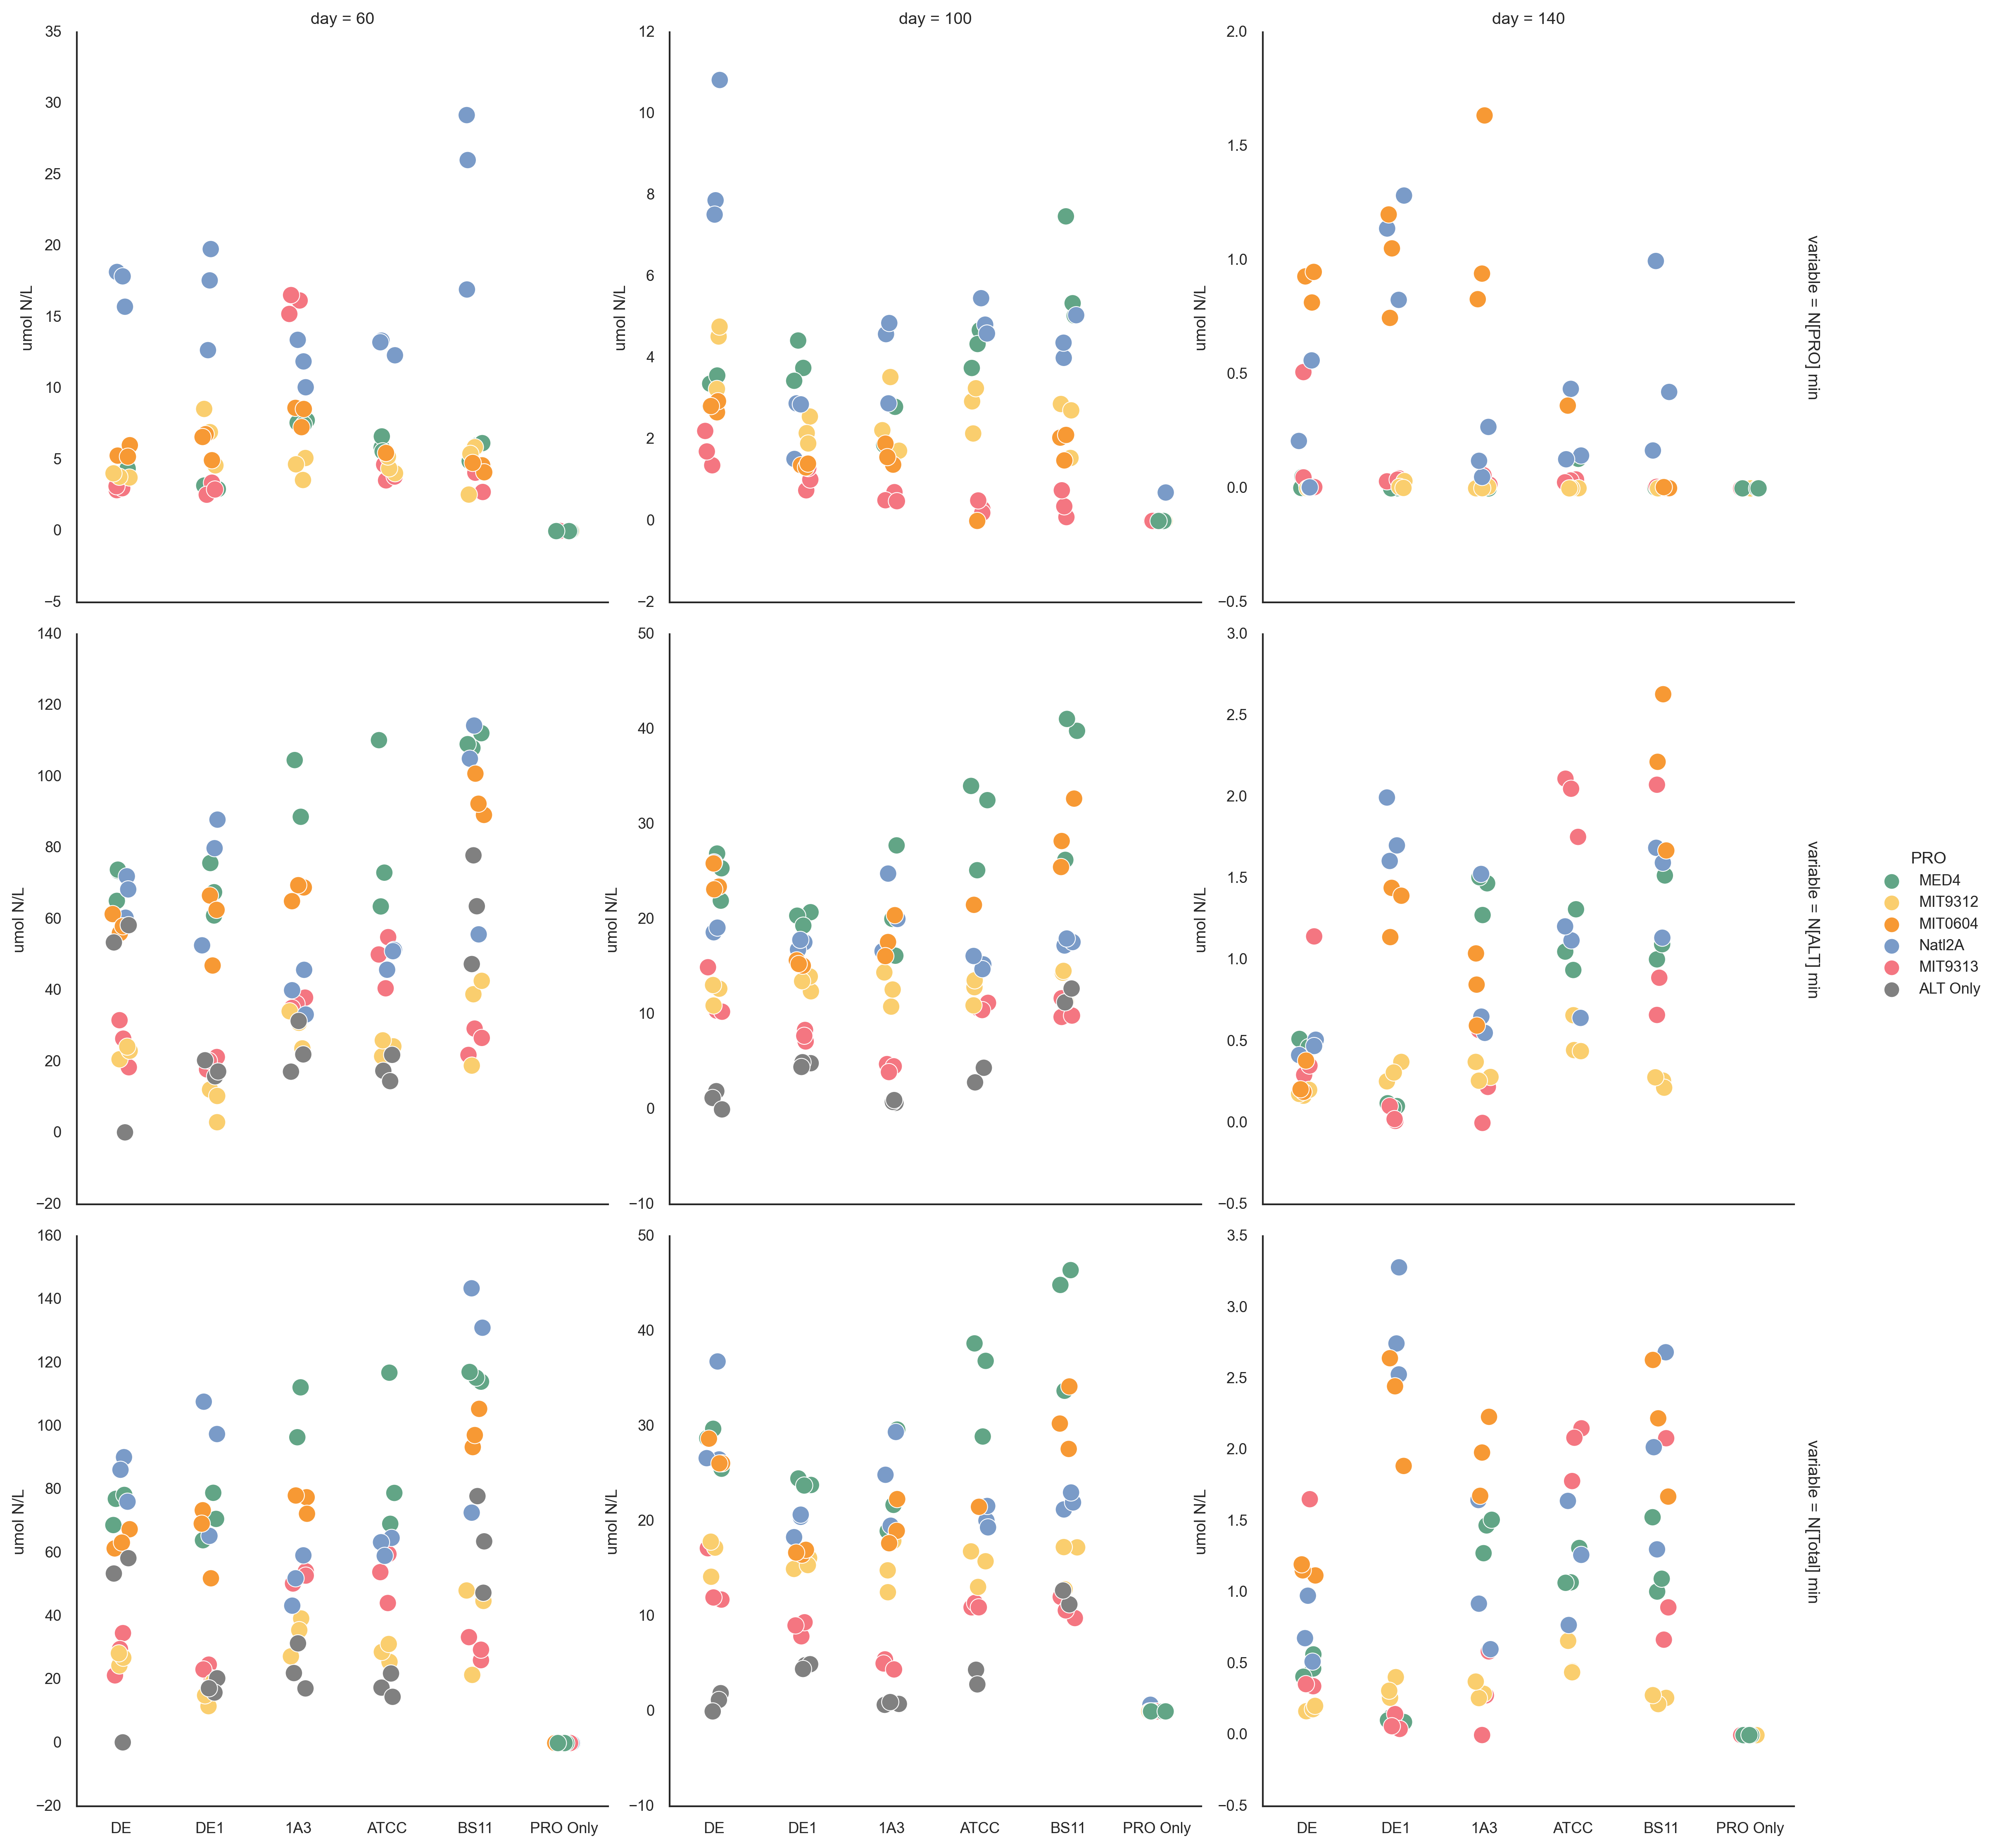

In [72]:

sns.set_context('paper')
g = sns.catplot(data=mdf.loc[mdf.variable.isin(['N[ALT] min','N[PRO] min', 'N[Total] min', 
                                               ]) ],
            hue='PRO', y='value', #hue='culture', 
            col='day',x='ALT', row='variable',
            #kind='box', 
            #kind='swarm',
            order=aorder + ['PRO Only'],
            #palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],

            hue_order=porder + ['ALT Only'],
            palette=ppallete + ['grey'], 
            dodge=False,
            sharey=False, margin_titles=True,
                edgecolor='white', linewidth=0.5,
                s=10, 
           ).set(ylabel='umol N/L', xlabel='', 
                 #ylim=(-200, 2500)
                 #yscale='log'
                )
#for ax in g.axes.flat:
#    ax.axhline(initial_N_max, ls='--', label='Total N in media')

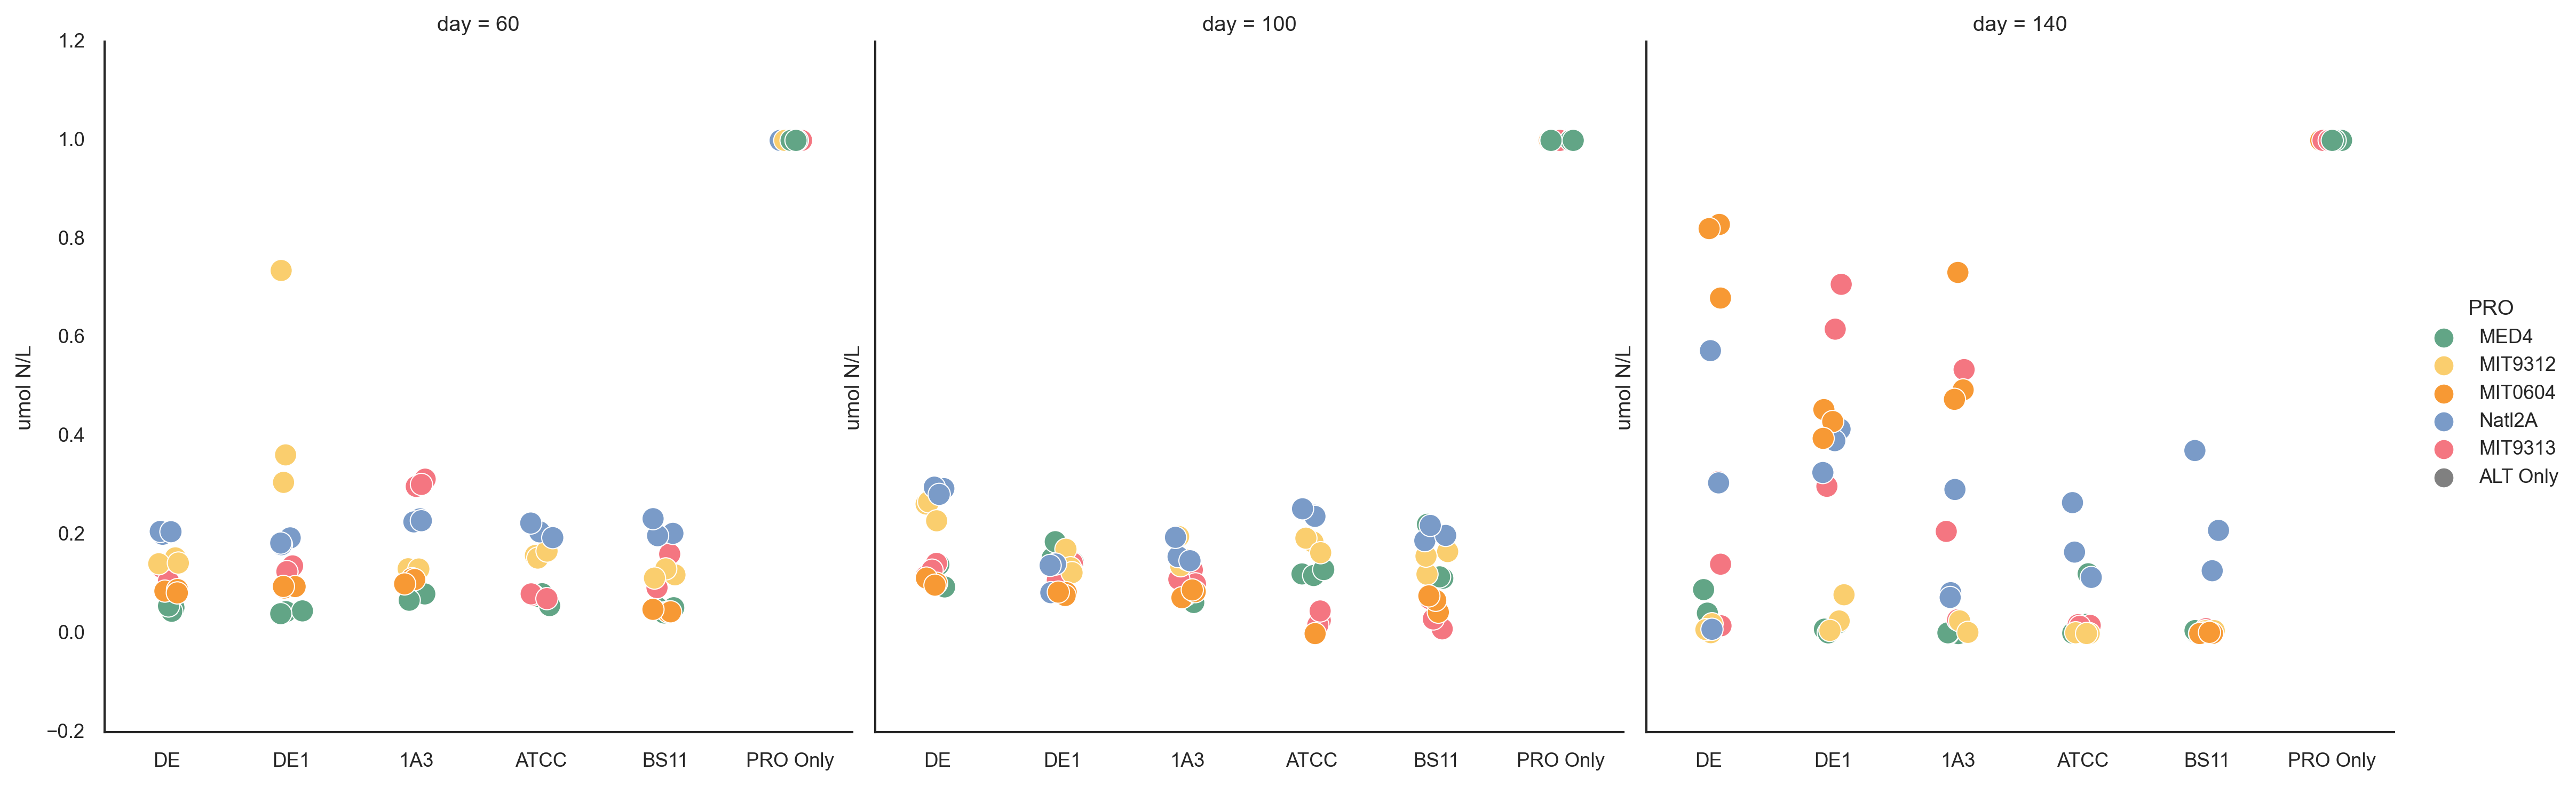

In [73]:

sns.set_context('paper')
g = sns.catplot(data=mdf.loc[mdf.variable.isin(['percent_PRO', #'N[Total] max'
                                               ]) ],
            hue='PRO', y='value', #hue='culture', 
            col='day',x='ALT',
            #kind='box', 
            #kind='swarm',
            order=aorder + ['PRO Only'],
            #palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],

            hue_order=porder + ['ALT Only'],
            palette=ppallete + ['grey'], 
            dodge=False,
            #sharey=False,
                edgecolor='white', linewidth=0.5,
                s=10, 
           ).set(ylabel='umol N/L', xlabel='', 
                # ylim=(0, 0.6)
                 #yscale='log'
                )

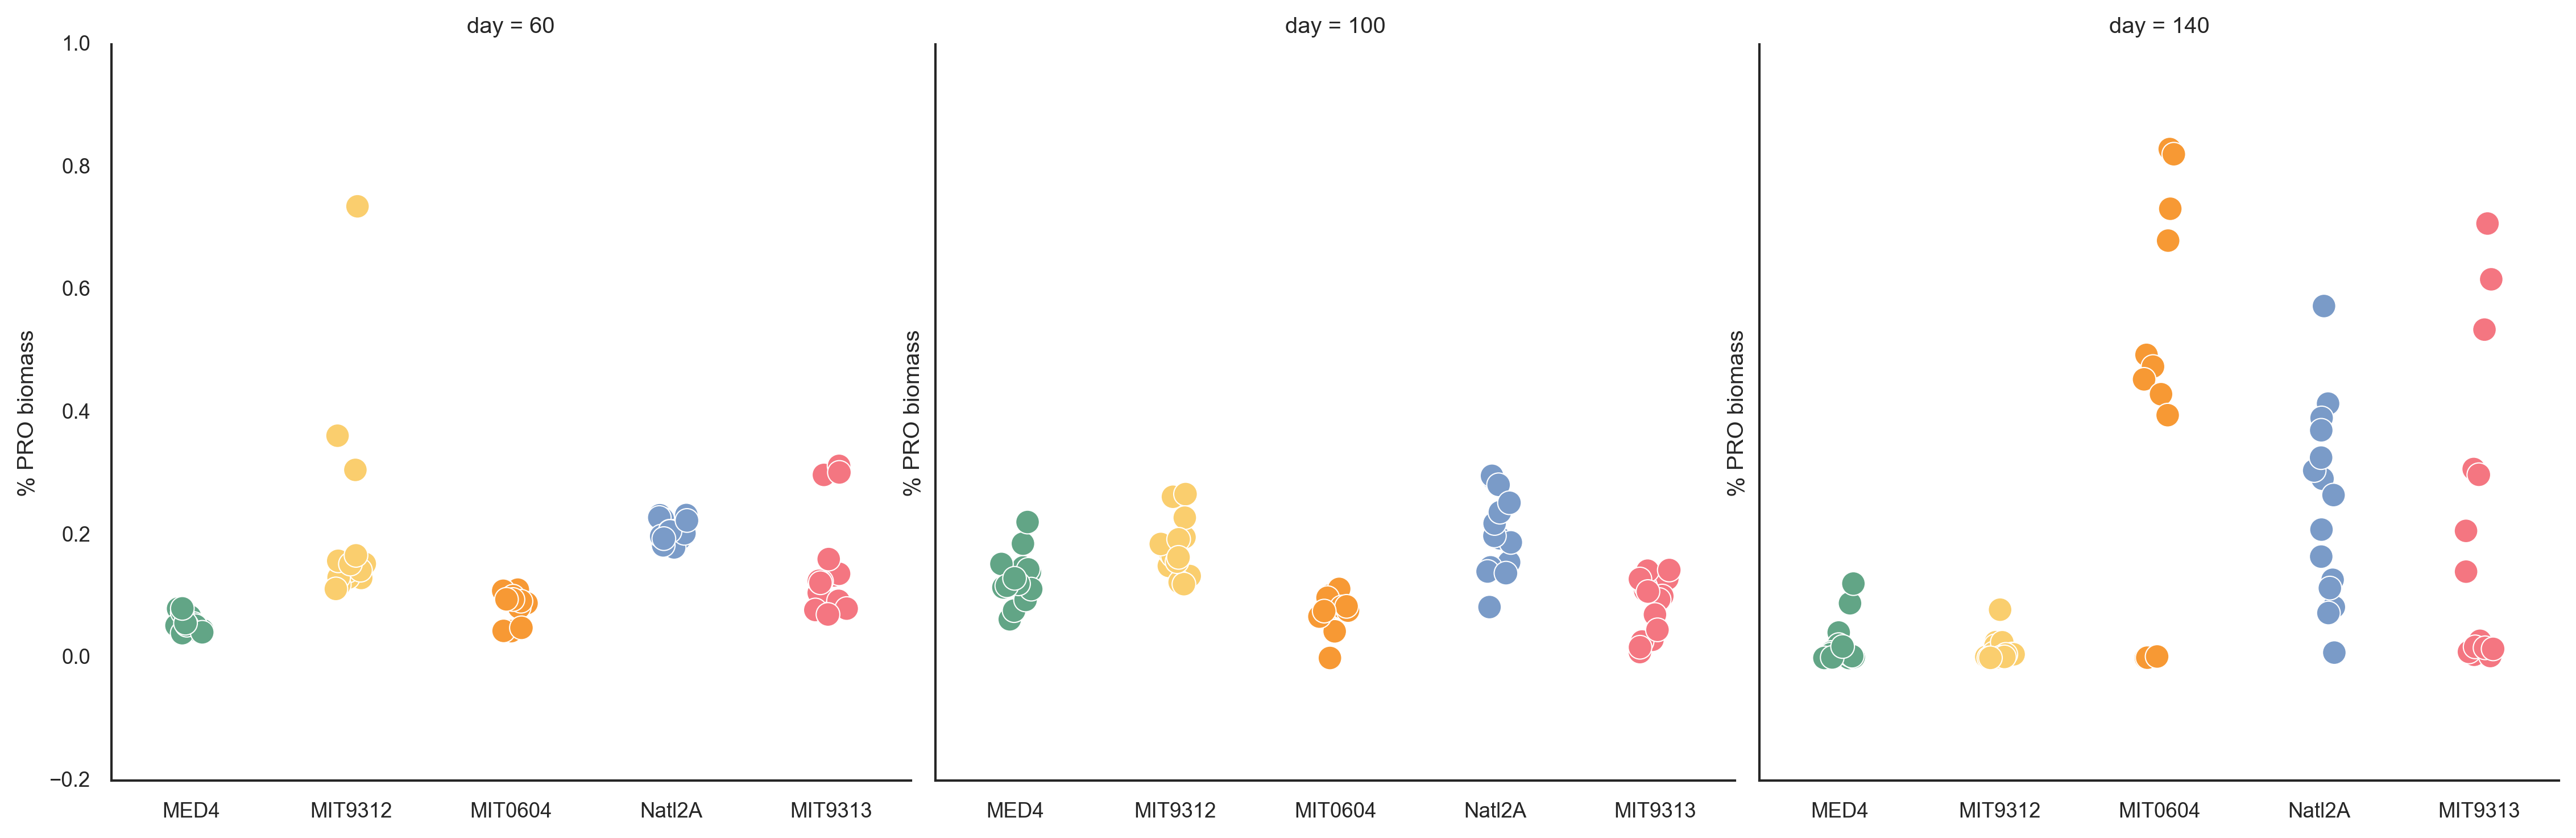

In [74]:

sns.set_context('paper')
g = sns.catplot(data=mdf.loc[mdf.variable.isin(['percent_PRO', #'N[Total] max'
                                               ]) &mdf.culture.isin(['Co_Culture']) ],
            hue='PRO', y='value', #hue='culture', 
            col='day',x='PRO',
            #kind='box', 
            #kind='swarm',
            order=porder ,
            #palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],

            hue_order=porder + ['ALT Only'],
            palette=ppallete + ['grey'], 
            dodge=False,
            #sharey=False,
                edgecolor='white', linewidth=0.5,
                s=10, 
           ).set(ylabel='% PRO biomass', xlabel='', 
                 #ylim=(0, 1)
                 #yscale='log'
                )

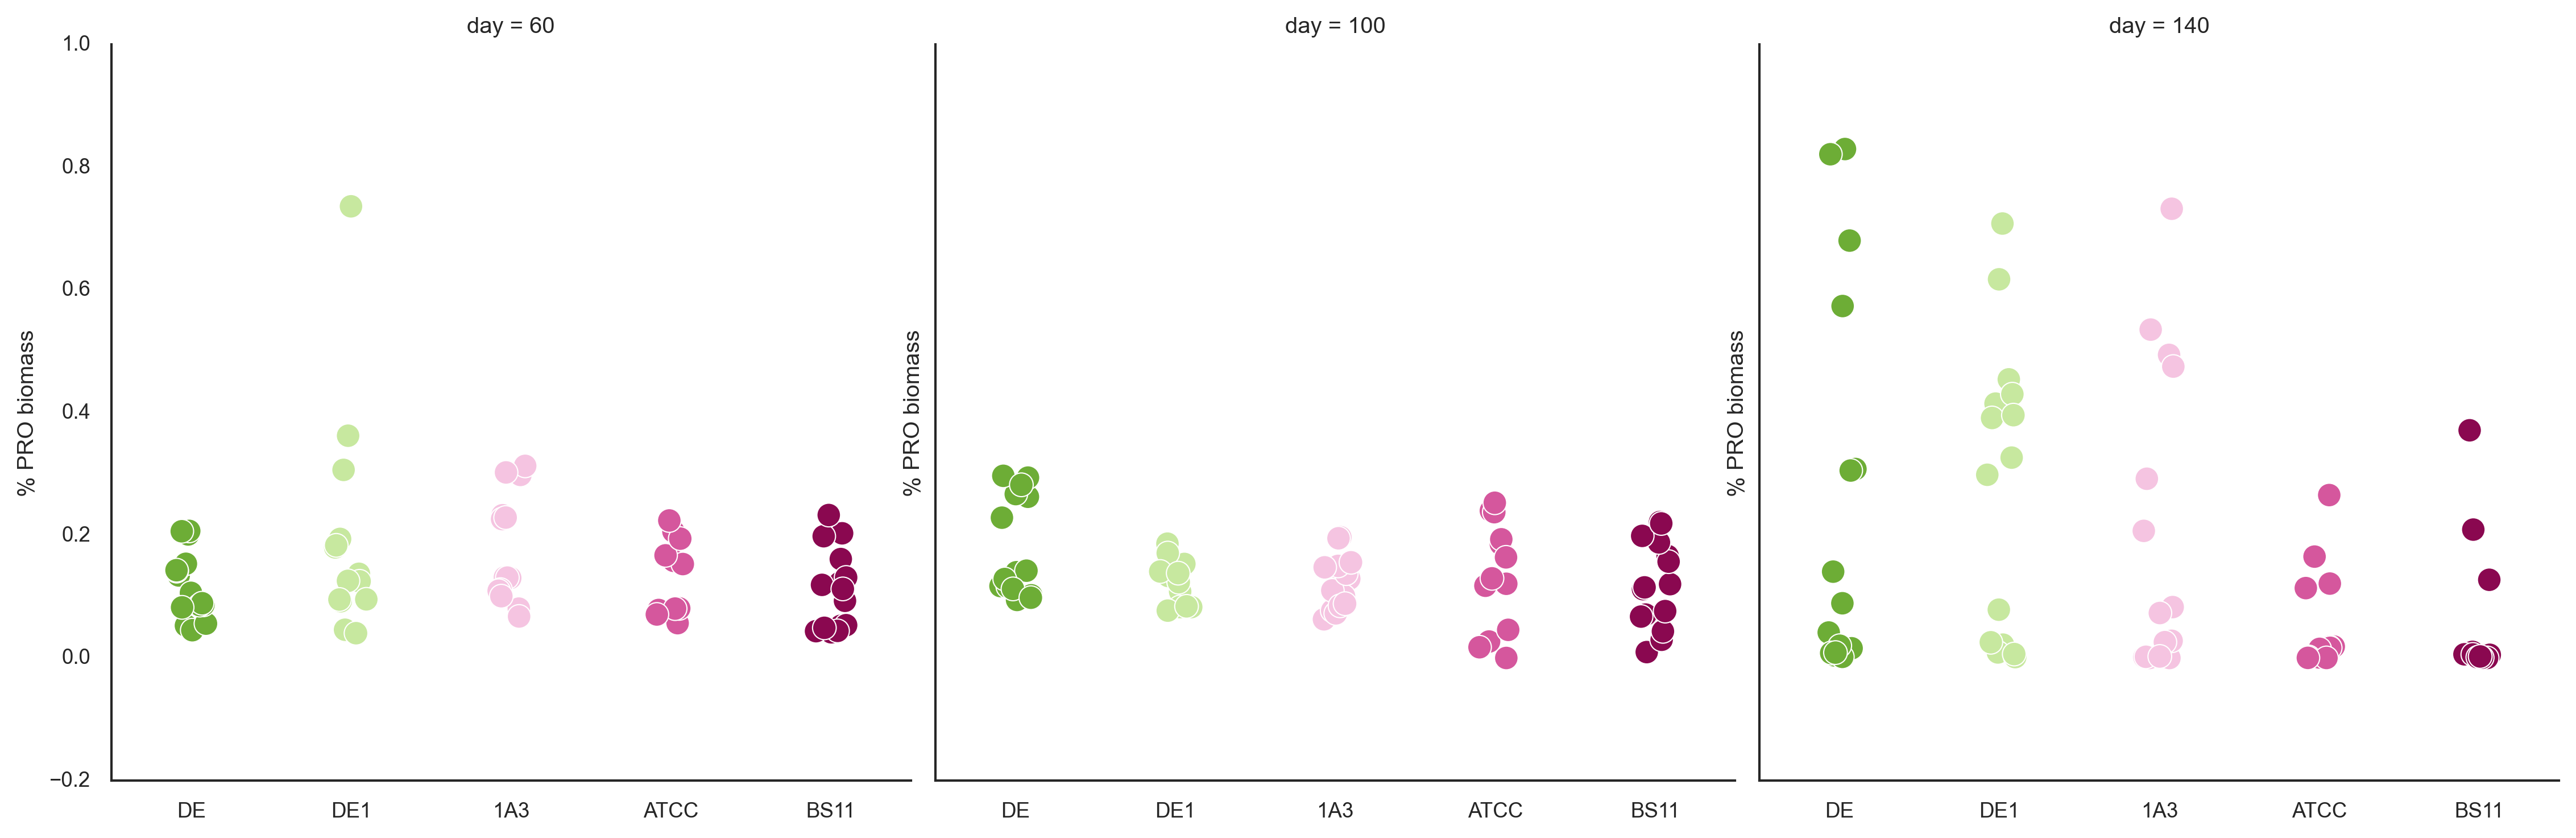

In [75]:

sns.set_context('paper')
g = sns.catplot(data=mdf.loc[mdf.variable.isin(['percent_PRO', #'N[Total] max'
                                               ]) &mdf.culture.isin(['Co_Culture']) ],
            hue='ALT', y='value', #hue='culture', 
            col='day',x='ALT',
            #kind='box', 
            #kind='swarm',
            order=aorder ,
            #palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],

            hue_order=aorder + ['ALT Only'],
            palette=apallete + ['grey'], 
            dodge=False,
            #sharey=False,
                edgecolor='white', linewidth=0.5,
                s=10, 
           ).set(ylabel='% PRO biomass', xlabel='', 
                 #ylim=(0, 1)
                 #yscale='log'
                )

In [76]:
df.groupby(['culture', 'day', 'PRO']).agg(['mean', 'std'])['percent_PRO']

mean       std
culture    day      PRO                         
ALT Only   60       ALT Only       NaN       NaN
           100      ALT Only       NaN       NaN
           140      ALT Only       NaN       NaN
Co_Culture 60       MED4      0.056690  0.013848
                    MIT0604   0.083409  0.024254
                    MIT9312   0.205263  0.162965
                    MIT9313   0.149137  0.084413
                    Natl2A    0.208110  0.017268
           100      MED4      0.129466  0.039795
                    MIT0604   0.076299  0.028562
                    MIT9312   0.177277  0.046178
                    MIT9313   0.085038  0.047412
                    Natl2A    0.204839  0.063624
           140      MED4      0.021330  0.036432
                    MIT0604   0.442998  0.305189
                    MIT9312   0.012461  0.020373
                    MIT9313   0.195197  0.245903
                    Natl2A    0.248159  0.155167
           exp3_140 MED4      0.169538  0.200301
                    MIT0604   0.168681  0.191409
                    MIT9312   0.039397  0.067636
                    MIT9313   0.266266  0.247299
                    Natl2A    0.127991  0.112065
           exp4_140 MED4      0.173987  0.070180
                    MIT0604   0.192818  0.144518
                    MIT9312   0.083072  0.053176
                    MIT9313   0.076123  0.198070
                    Natl2A    0.015539  0.011872
PRO Only   60       MED4      1.000000  0.000000
                    MIT0604   1.000000  0.000000
                    MIT9312   1.000000  0.000000
                    MIT9313   1.000000  0.000000
                    Natl2A    1.000000  0.000000
           100      MED4      1.000000  0.000000
                    MIT0604   1.000000  0.000000
                    MIT9312   1.000000  0.000000
                    MIT9313   1.000000  0.000000
                    Natl2A    1.000000  0.000000
           140      MED4      1.000000  0.000000
                    MIT0604   1.000000  0.000000
                    MIT9312   1.000000  0.000000
                    MIT9313   1.000000  0.000000
                    Natl2A    1.000000  0.000000

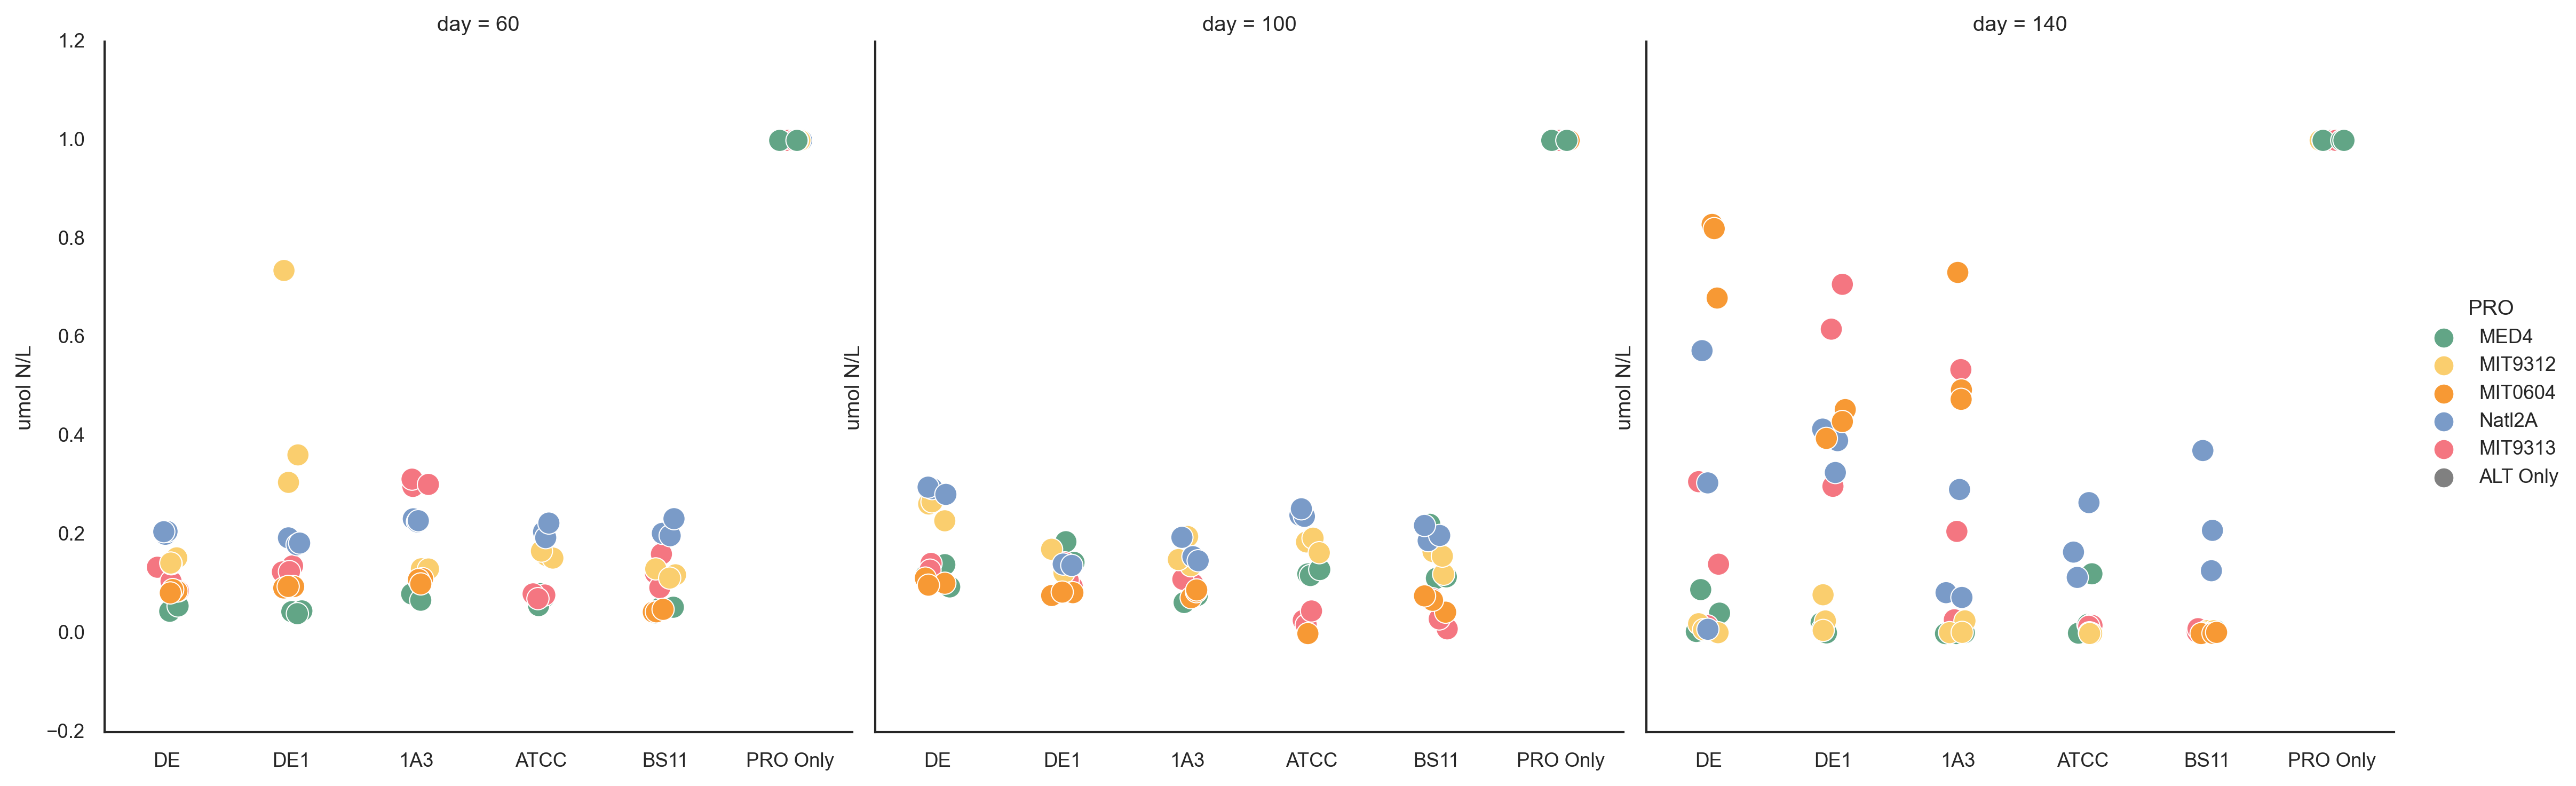

In [77]:

sns.set_context('paper')
g = sns.catplot(data=mdf.loc[mdf.variable.isin(['percent_PRO', #'N[Total] max'
                                               ]) ],
            hue='PRO', y='value', #hue='culture', 
            col='day',x='ALT',
            #kind='box', 
            #kind='swarm',
            order=aorder + ['PRO Only'],
            #palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],

            hue_order=porder + ['ALT Only'],
            palette=ppallete + ['grey'], 
            dodge=False,
            #sharey=False,
                edgecolor='white', linewidth=0.5,
                s=10, 
           ).set(ylabel='umol N/L', xlabel='', 
                # ylim=(0, 1)
                 #yscale='log'
                )

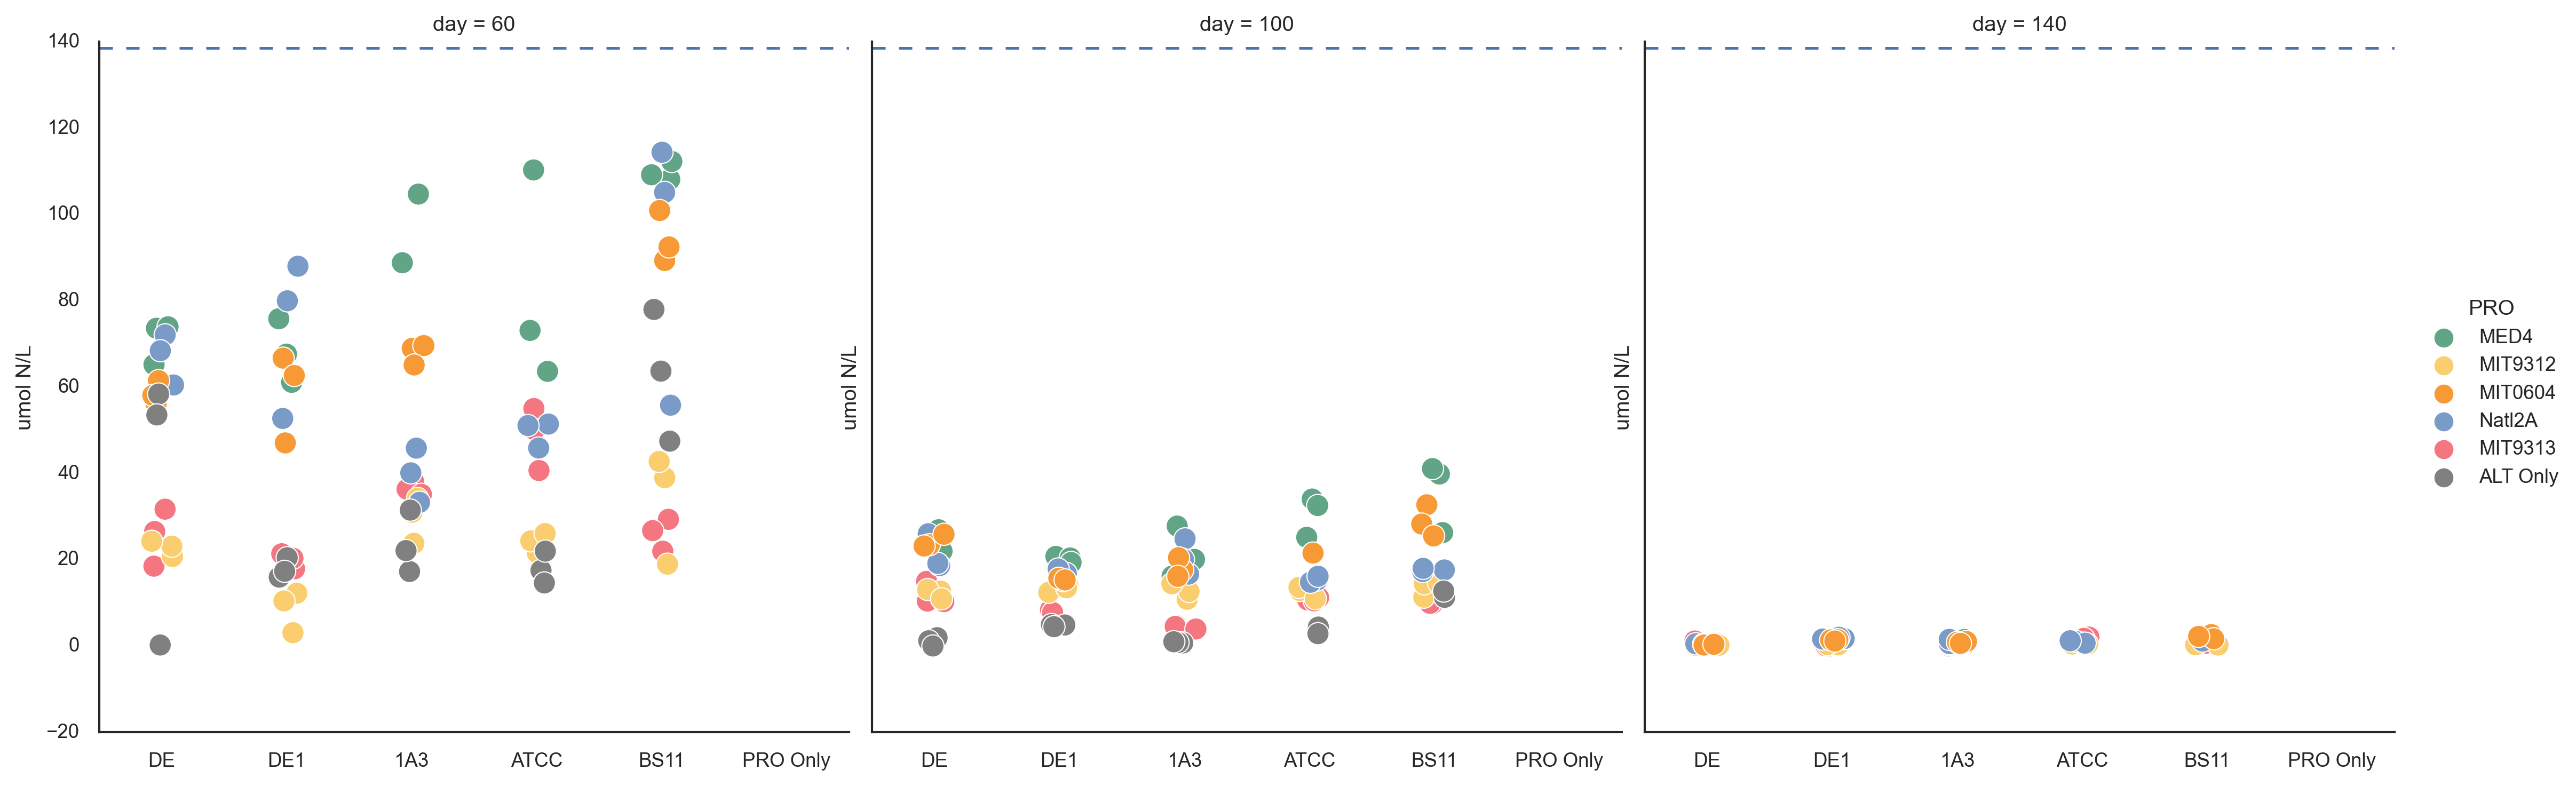

In [78]:

sns.set_context('paper')
g = sns.catplot(data=mdf.loc[mdf.variable.isin(['N[ALT] min', #'N[Total] max'
                                               ]) ],
            hue='PRO', y='value', #hue='culture', 
            col='day',x='ALT',
            #kind='box', 
            #kind='swarm',
            order=aorder + ['PRO Only'],
            #palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],

            hue_order=porder + ['ALT Only'],
            palette=ppallete + ['grey'], 
            dodge=False,
            #sharey=False,
                edgecolor='white', linewidth=0.5,
                s=10, 
           ).set(ylabel='umol N/L', xlabel='', 
                 #ylim=(-200, 2500)
                 #yscale='log'
                )
for ax in g.axes.flat:
    ax.axhline(initial_N_max, ls='--', label='Total N in media')

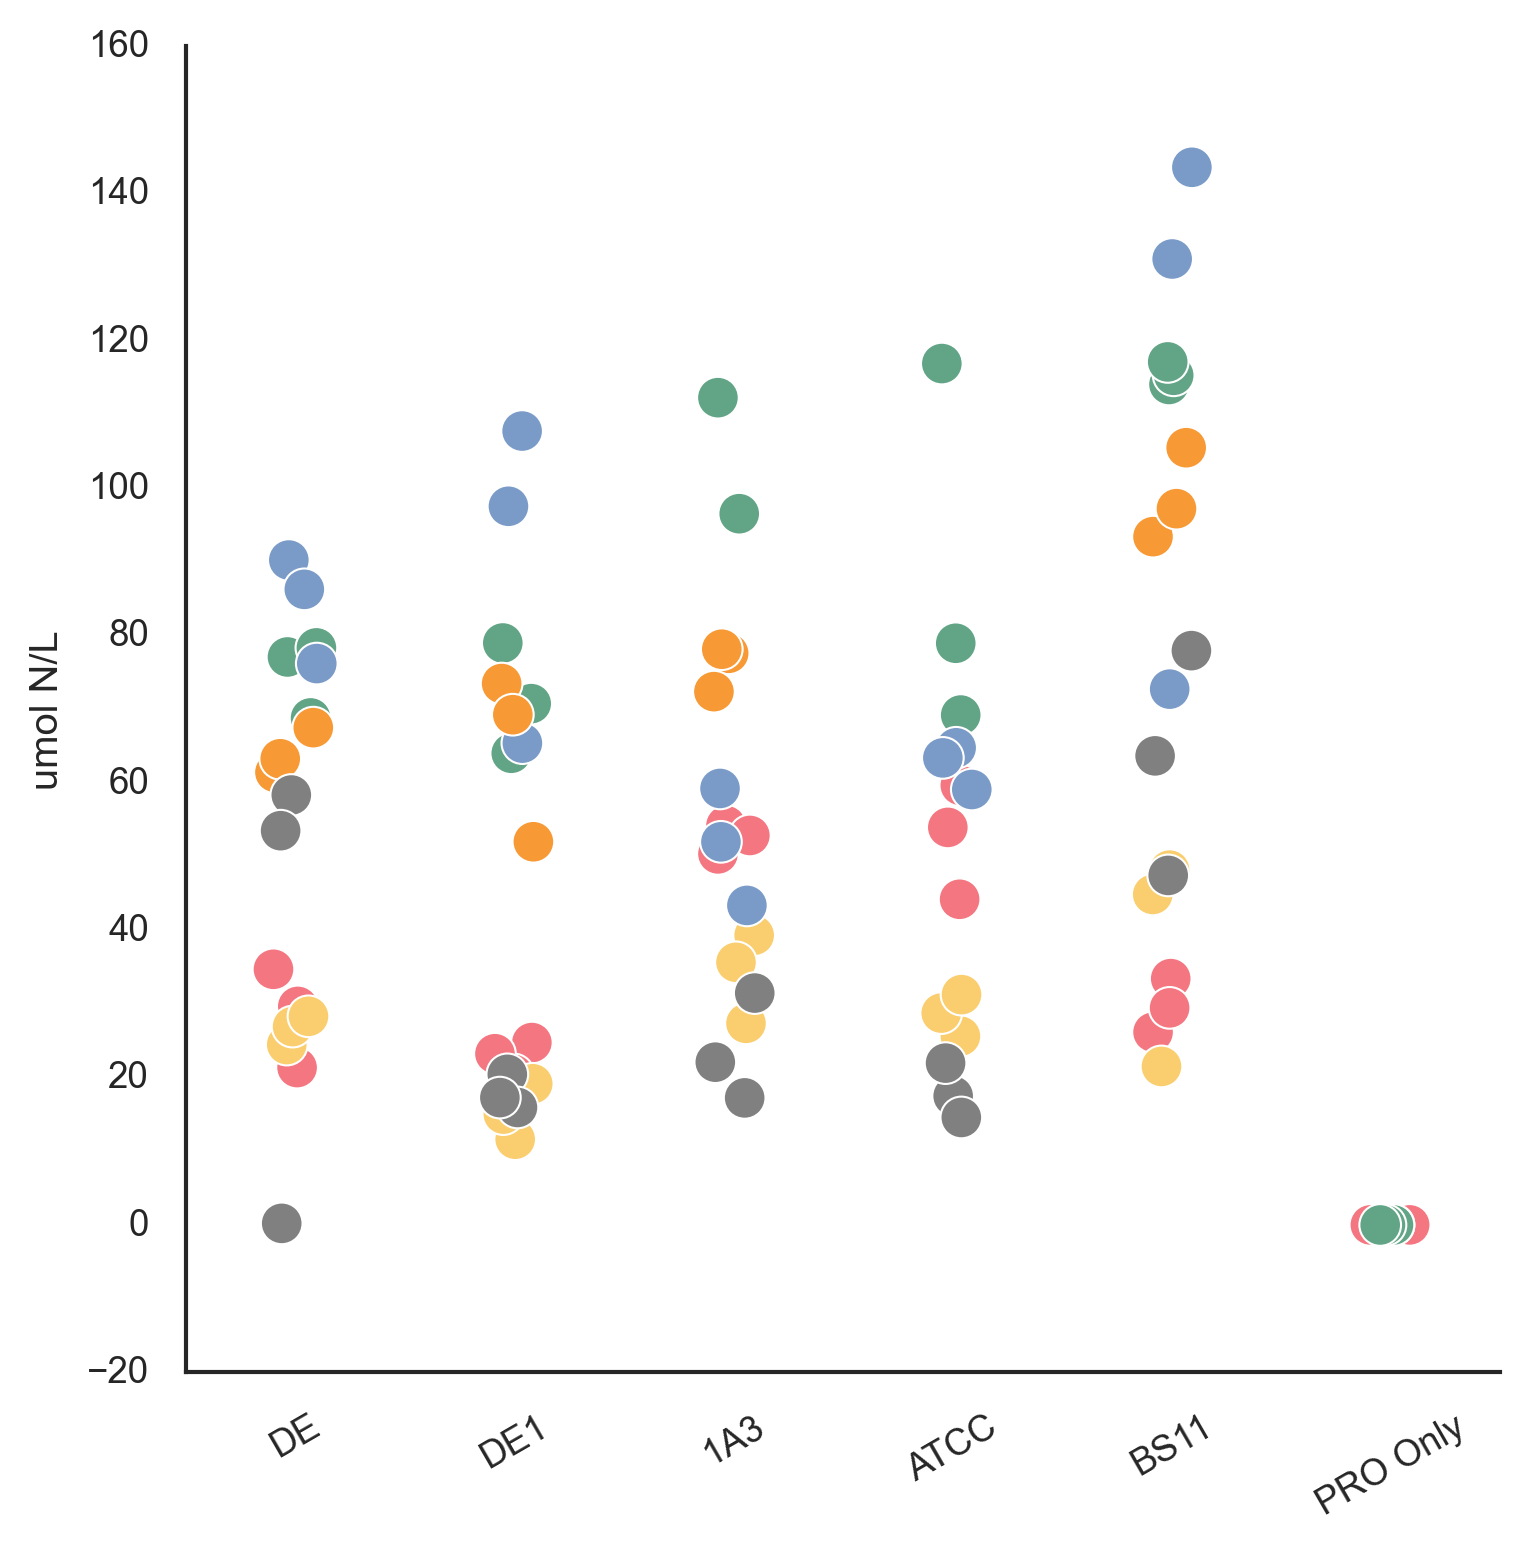

In [79]:

g = sns.catplot(data=mdf.loc[mdf.variable.isin(['N[Total] min', #'N[Total] max'
                                               ]) &
                             (mdf.day == 60)
                            ],
            hue='PRO', y='value', #hue='culture', 
            x='ALT',
            #kind='box', 
            #kind='swarm',
            order=aorder + ['PRO Only'],
            #palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],

            hue_order=porder + ['ALT Only'],
            palette=ppallete + ['grey'], 
            dodge=False,
                edgecolor='white', linewidth=0.5,
            sharey=False,
                legend=False,
                s=10, 
           ).set(ylabel='umol N/L', xlabel='', 
                 #ylim=(-5, 50)
                 #yscale='log'
                ).set_xticklabels(rotation=30) 
#for ax in g.axes.flat:
#    ax.axhline(initial_N_max, ls='--', label='Total N in media')

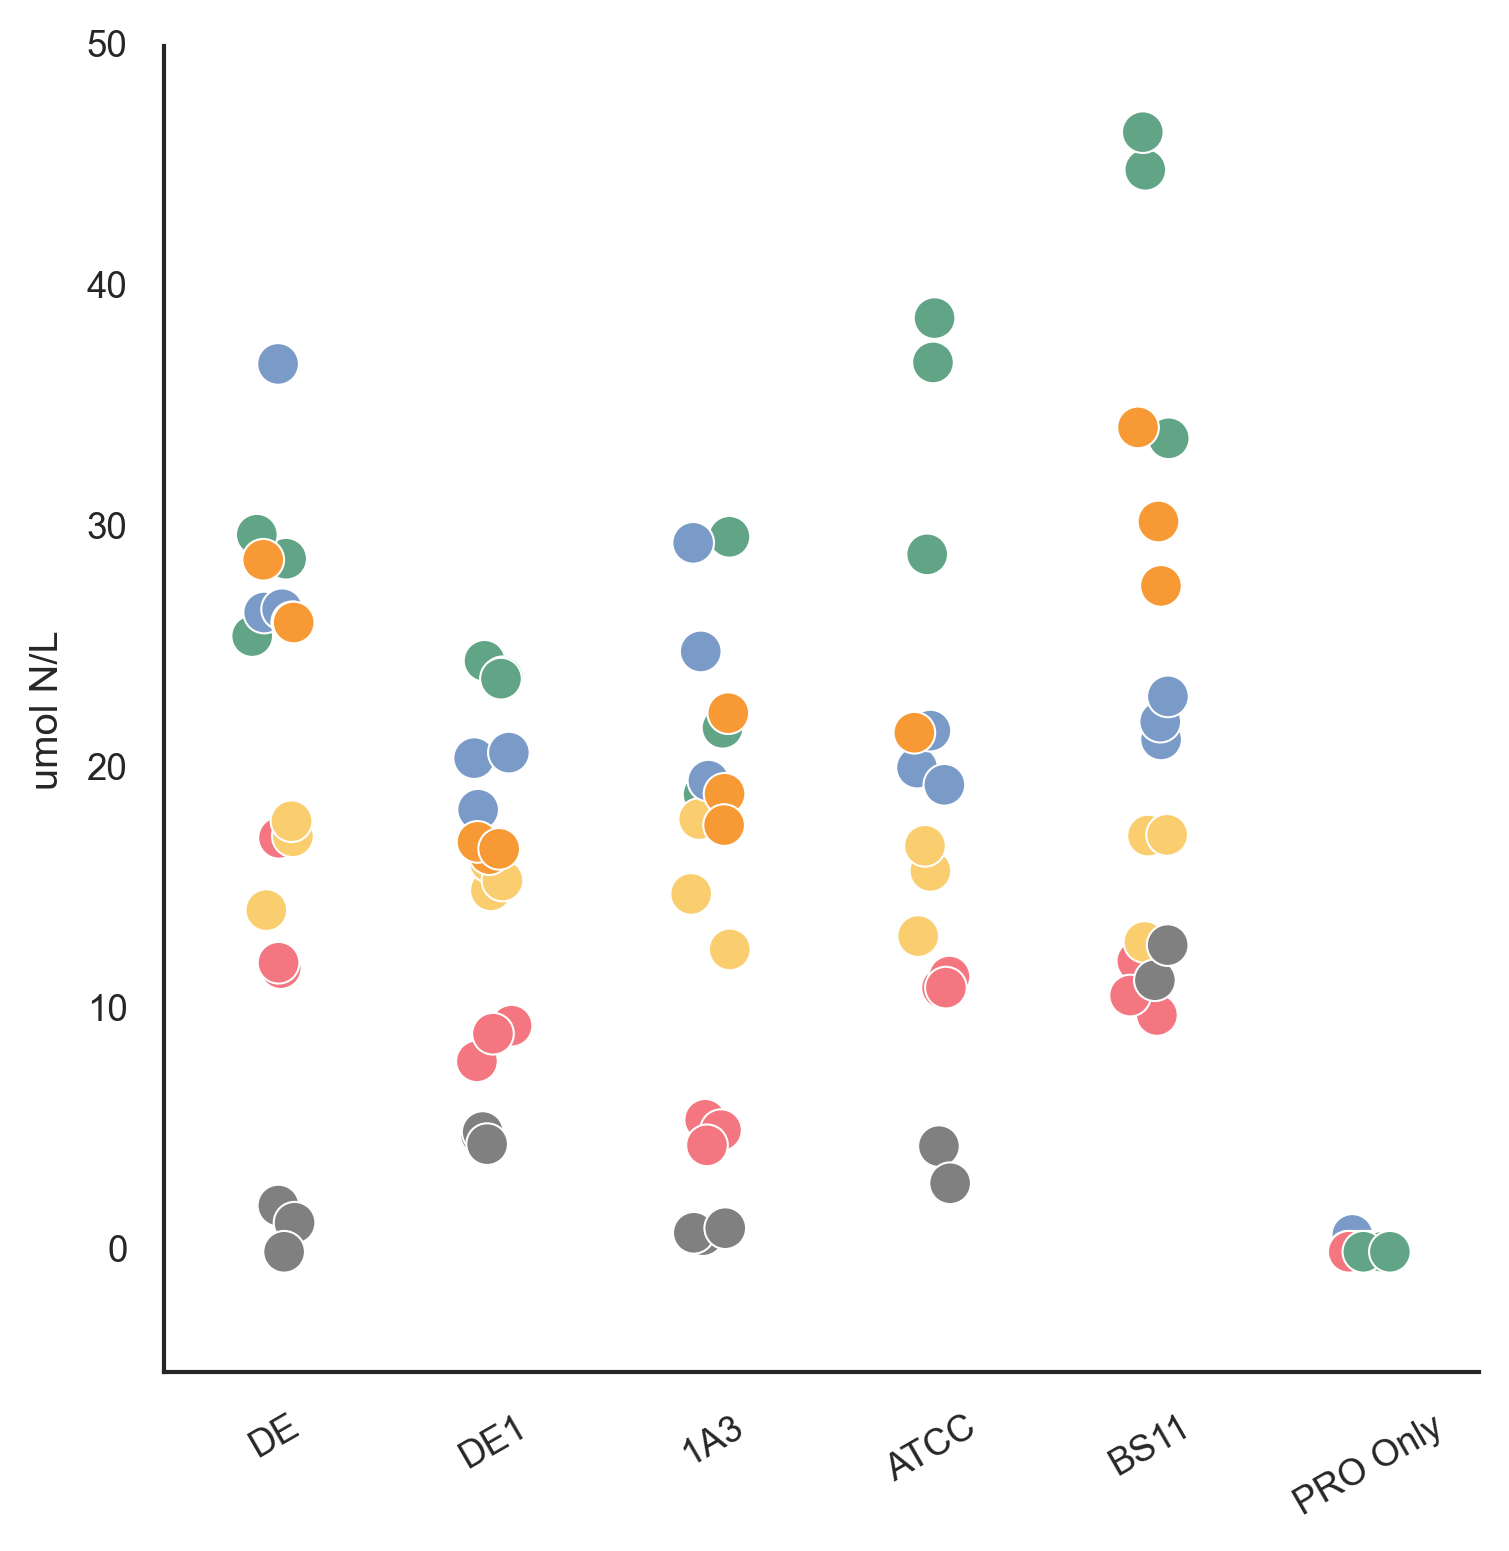

In [80]:

g = sns.catplot(data=mdf.loc[mdf.variable.isin(['N[Total] min', #'N[Total] max'
                                               ]) &
                             (mdf.day == 100)
                            ],
            hue='PRO', y='value', #hue='culture', 
            x='ALT',
            #kind='box', 
            #kind='swarm',
            order=aorder + ['PRO Only'],
            #palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],

            hue_order=porder + ['ALT Only'],
            palette=ppallete + ['grey'], 
            dodge=False,
                edgecolor='white', linewidth=0.5,
            sharey=False,
                legend=False,
                s=10, 
           ).set(ylabel='umol N/L', xlabel='', 
                 ylim=(-5, 50)
                 #yscale='log'
                ).set_xticklabels(rotation=30) 
#for ax in g.axes.flat:
#    ax.axhline(initial_N_max, ls='--', label='Total N in media')

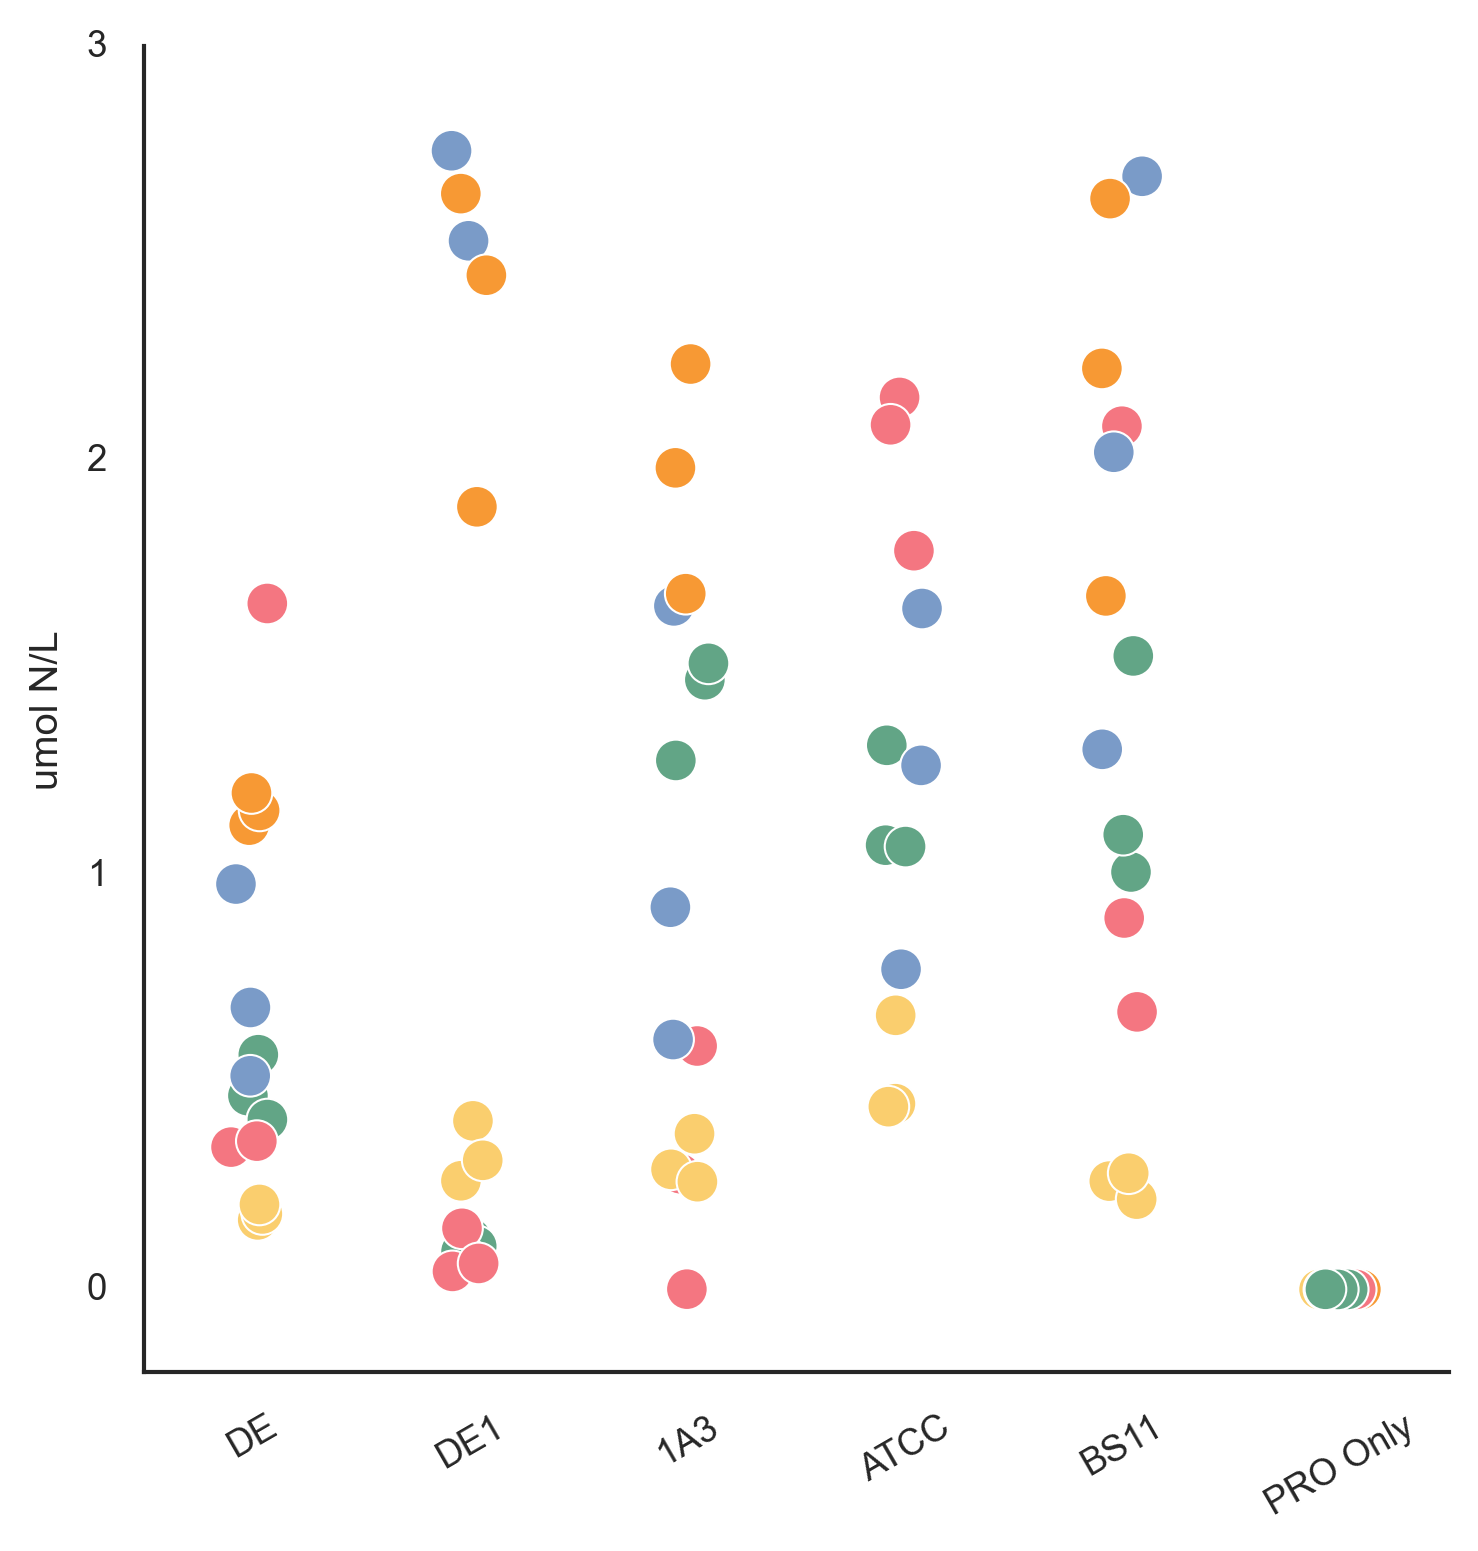

In [81]:

g = sns.catplot(data=mdf.loc[mdf.variable.isin(['N[Total] min', #'N[Total] max'
                                               ]) &
                             (mdf.day == 140)
                            ],
            hue='PRO', y='value', #hue='culture', 
            x='ALT',
            #kind='box', 
            #kind='swarm',
            order=aorder + ['PRO Only'],
            #palette=['#1B73D3', PRO_COLOR, ALT_COLOR, ], hue_order=['Co_Culture', 'PRO Only', 'ALT Only', ],

            hue_order=porder + ['ALT Only'],
            palette=ppallete + ['grey'], 
            dodge=False,
                edgecolor='white', linewidth=0.5,
            sharey=False,
                legend=False,
                s=10, 
           ).set(ylabel='umol N/L', xlabel='', 
                 ylim=(-0.2, 3), yticks=[0,1,2,3]
                 #yscale='log'
                ).set_xticklabels(rotation=30) 
#for ax in g.axes.flat:
#    ax.axhline(initial_N_max, ls='--', label='Total N in media')

In [82]:
df['totalN']  = df['N[Total] min'] 

In [83]:
df['ALTN']  = df['N[ALT] min'] 

In [84]:
from statsmodels.formula.api import ols

for a in aorder:
    for d in [60, 100]:
        dfdata=df.loc[df.ALT.isin([a]) & (df.day == d)]

        mod = ols('totalN ~ C(PRO)',
                        data=dfdata).fit()
        print (f'++++++++++++++++++ {a} +++++++++++++++++++++++')
        #print(mod.summary())
        #print(sm.stats.anova_lm(mod))
        print(f'=== {a} day {d} === totalN as function of ALT strain')
        pair_t = mod.t_test_pairwise("C(PRO)", method='b')
        #print(pair_t.result_frame)
        print(f'=== {a} day {d} === totalN as function of ALT strain')
        print(pair_t.result_frame.loc[pair_t.result_frame['reject-b'], 'pvalue-b'])
        #aov_table = sm.stats.anova_lm(mod, typ=2)
        #print(aov_table)

++++++++++++++++++ DE +++++++++++++++++++++++
=== DE day 60 === totalN as function of ALT strain
=== DE day 60 === totalN as function of ALT strain
Natl2A-ALT Only    0.022242
MIT9312-MED4       0.018184
MIT9313-MED4       0.024847
Natl2A-MIT9312     0.004349
Natl2A-MIT9313     0.005835
Name: pvalue-b, dtype: float64
++++++++++++++++++ DE +++++++++++++++++++++++
=== DE day 100 === totalN as function of ALT strain
=== DE day 100 === totalN as function of ALT strain
MED4-ALT Only       0.000002
MIT0604-ALT Only    0.000004
MIT9312-ALT Only    0.000739
MIT9313-ALT Only    0.004336
Natl2A-ALT Only     0.000001
MIT9312-MED4        0.008627
MIT9313-MED4        0.001381
MIT9312-MIT0604     0.017832
MIT9313-MIT0604     0.002681
Natl2A-MIT9312      0.002286
Natl2A-MIT9313      0.000414
Name: pvalue-b, dtype: float64
++++++++++++++++++ DE1 +++++++++++++++++++++++
=== DE1 day 60 === totalN as function of ALT strain
=== DE1 day 60 === totalN as function of ALT strain
MED4-ALT Only       0.000855
M

In [85]:
from statsmodels.formula.api import ols

for a in aorder:
    for d in [60, 100]:
        dfdata=df.loc[df.ALT.isin([a]) & (df.day == d)]

        mod = ols('ALTN ~ C(PRO)',
                        data=dfdata).fit()
        print (f'++++++++++++++++++ {a} +++++++++++++++++++++++')
        #print(mod.summary())
        #print(sm.stats.anova_lm(mod))
        print(f'=== {a} day {d} === ALTN as function of ALT strain')
        pair_t = mod.t_test_pairwise("C(PRO)", method='b')
        #print(pair_t.result_frame)
        print(f'=== {a} day {d} === ALTN as function of ALT strain')
        print(pair_t.result_frame.loc[pair_t.result_frame['reject-b'], 'pvalue-b'])
        #aov_table = sm.stats.anova_lm(mod, typ=2)
        #print(aov_table)

++++++++++++++++++ DE +++++++++++++++++++++++
=== DE day 60 === ALTN as function of ALT strain
=== DE day 60 === ALTN as function of ALT strain
MIT9312-MED4      0.016780
MIT9313-MED4      0.026352
Natl2A-MIT9312    0.031227
Natl2A-MIT9313    0.049475
Name: pvalue-b, dtype: float64
++++++++++++++++++ DE +++++++++++++++++++++++
=== DE day 100 === ALTN as function of ALT strain
=== DE day 100 === ALTN as function of ALT strain
MED4-ALT Only       7.072811e-07
MIT0604-ALT Only    9.381100e-07
MIT9312-ALT Only    1.534848e-03
MIT9313-ALT Only    2.053254e-03
Natl2A-ALT Only     4.103920e-06
MIT9312-MED4        5.518272e-04
MIT9313-MED4        4.214764e-04
MIT9312-MIT0604     8.692852e-04
MIT9313-MIT0604     6.589726e-04
Natl2A-MIT9312      9.622187e-03
Natl2A-MIT9313      7.026675e-03
Name: pvalue-b, dtype: float64
++++++++++++++++++ DE1 +++++++++++++++++++++++
=== DE1 day 60 === ALTN as function of ALT strain
=== DE1 day 60 === ALTN as function of ALT strain
MED4-ALT Only       0.000432
M

In [86]:
from statsmodels.formula.api import ols

for d in [60, 100]:
    dfdata=df.loc[df.culture.isin(['Co_Culture']) & (df.day == d)]

    mod = ols('percent_PRO ~ C(PRO)',
                    data=dfdata).fit()
    print (f'++++++++++++++++++ {a} +++++++++++++++++++++++')
    #print(mod.summary())
    #print(sm.stats.anova_lm(mod))
    print(f'=== day {d} === percent_PRO as function of PRO strain')
    pair_t = mod.t_test_pairwise("C(PRO)", method='b')
    #print(pair_t.result_frame)
    print(f'=== day {d} === percent_PRO as function of PRO strain')
    print(pair_t.result_frame.loc[pair_t.result_frame['reject-b'], 'pvalue-b'])
    #aov_table = sm.stats.anova_lm(mod, typ=2)
    #print(aov_table)

++++++++++++++++++ BS11 +++++++++++++++++++++++
=== day 60 === percent_PRO as function of PRO strain
=== day 60 === percent_PRO as function of PRO strain
MIT9312-MED4       0.000155
Natl2A-MED4        0.000112
MIT9312-MIT0604    0.004845
Natl2A-MIT0604     0.003661
Name: pvalue-b, dtype: float64
++++++++++++++++++ BS11 +++++++++++++++++++++++
=== day 100 === percent_PRO as function of PRO strain
=== day 100 === percent_PRO as function of PRO strain
MIT0604-MED4       3.906394e-02
Natl2A-MED4        3.973676e-04
MIT9312-MIT0604    3.118829e-06
Natl2A-MIT0604     5.606016e-09
MIT9313-MIT9312    9.953854e-06
Natl2A-MIT9313     1.500028e-08
Name: pvalue-b, dtype: float64


In [87]:
df.to_csv('capacity.csv.gz')